In [6]:
import pandas as pd
import numpy as np
import holidays
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [7]:
df = pd.read_csv("C:/Users/fdcontreras/Downloads/retail-demand-uniandes/data/01_raw/olist_consolidated_dataset_v2.csv")

In [8]:
df["order_purchase_timestamp"] = pd.to_datetime(
    df["order_purchase_timestamp"]
)
df["order_date"] = df["order_purchase_timestamp"].dt.date

In [10]:
category_daily = (
    df.groupby(["order_date", "product_category_name_english"])
    .size()
    .reset_index(name="num_orders")
)

In [11]:
category_daily

order_date            product_category_name_english  num_orders
0      2016-09-04                          furniture_decor           2
1      2016-09-05                                telephony           1
2      2016-09-15                            health_beauty           3
3      2016-10-02                                     baby           1
4      2016-10-03                            fashion_shoes           1
...           ...                                      ...         ...
18166  2018-08-29  kitchen_dining_laundry_garden_furniture           2
18167  2018-08-29                           sports_leisure           1
18168  2018-08-29                                     toys           1
18169  2018-08-29                            watches_gifts           2
18170  2018-09-03  kitchen_dining_laundry_garden_furniture           1

[18171 rows x 3 columns]

In [12]:
dias_por_categoria = (
    category_daily.groupby("product_category_name_english")["order_date"]
    .nunique()
    .sort_values(ascending=False)
)
print(dias_por_categoria)

product_category_name_english
furniture_decor                            607
sports_leisure                             603
health_beauty                              602
bed_bath_table                             598
computers_accessories                      593
toys                                       590
telephony                                  588
housewares                                 587
garden_tools                               585
cool_stuff                                 584
auto                                       582
perfumery                                  580
watches_gifts                              571
baby                                       562
fashion_bags_accessories                   541
pet_shop                                   524
stationery                                 517
electronics                                511
luggage_accessories                        458
office_furniture                           454
consoles_games                

In [13]:
dias_por_categoria = (
    category_daily.groupby("product_category_name_english")["order_date"]
    .nunique()
    .reset_index(name="dias_con_ventas")
)

In [14]:
categorias_menos_45 = dias_por_categoria[dias_por_categoria["dias_con_ventas"] > 45][
    "product_category_name_english"
]

In [15]:
category_daily_filtrado = df[
    df["product_category_name_english"].isin(categorias_menos_45)
]

In [16]:
category_daily_filtrado

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
116078  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
116079  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
116080  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
116081  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
116082  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp    order_approved_at  \
0         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3         delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4         delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
...             ...                      ...                  ...   
116078    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
116079    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
116080    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
116081    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
116082    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-10-04 19:55:00           2017-10-10 21:25:13   
2               2017-10-04 19:55:00           2017-10-10 21:25:13   
3               2018-07-26 14:31:00           2018-08-07 15:27:45   
4               2018-08-08 13:50:00           2018-08-17 18:06:29   
...                             ...                           ...   
116078          2018-02-07 23:22:42           2018-02-28 17:37:56   
116079          2017-08-28 20:52:26           2017-09-21 11:24:17   
116080          2018-01-12 15:35:03           2018-01-25 23:32:54   
116081          2018-01-12 15:35:03           2018-01-25 23:32:54   
116082          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date                customer_unique_id  \
0                2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1                2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
2                2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
3                2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
4                2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   
...                              ...                               ...   
116078           2018-03-02 00:00:00  da62f9e57a76d978d02ab5362c509660   
116079           2017-09-27 00:00:00  737520a9aad80b3fbbdad19b66b37b30   
116080           2018-02-15 00:00:00  5097a5312c8b157bb7be58ae360ef43c   
116081           2018-02-15 00:00:00  5097a5312c8b157bb7be58ae360ef43c   
116082           2018-04-03 00:00:00  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix  ... product_width_cm zip_code_prefix  \
0                           3149  ...             13.0          9350.0   
1                           3149  ...             13.0          9350.0   
2                           3149  ...             13.0          9350.0   
3                          47813  ...             19.0         31570.0   
4                          75265  ...             21.0         14840.0   
...                          ...  ...              ...             ...   
116078                     117

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def create_features(df_input, category_name):
    df_cat = df_input[df_input['product_category_name_english'] == category_name].copy()
    df_cat_daily = df_cat.groupby('order_date').size().reset_index(name='num_orders')
    df_cat_daily['order_date'] = pd.to_datetime(df_cat_daily['order_date'])
    df_cat_daily = df_cat_daily.set_index('order_date').asfreq('D', fill_value=0).reset_index()

    df_cat_daily['dayofweek'] = df_cat_daily['order_date'].dt.dayofweek
    df_cat_daily['is_weekend'] = (df_cat_daily['dayofweek'] >= 5).astype(int)
    br_holidays = holidays.Brazil(years=df_cat_daily['order_date'].dt.year.unique())
    df_cat_daily['is_holiday'] = df_cat_daily['order_date'].isin(br_holidays).astype(int)

    def is_black_friday(date):
        return date.month == 11 and date.weekday() == 4 and 22 <= date.day <= 28
    df_cat_daily['is_black_friday'] = df_cat_daily['order_date'].apply(is_black_friday).astype(int)

    df_cat_daily['lag_7'] = df_cat_daily['num_orders'].shift(7)
    df_cat_daily['rolling_mean_7'] = df_cat_daily['num_orders'].shift(1).rolling(window=7).mean()
    
    return df_cat_daily.dropna().set_index('order_date')

print("Funciones auxiliares listas.")

Funciones auxiliares listas.


In [ ]:
# Usa el DataFrame que ya filtraste en tu código anterior
df_to_process = category_daily_filtrado
categories_to_process = df_to_process['product_category_name_english'].unique()
all_results = []
test_size = 15

print(f"Iniciando procesamiento de {len(categories_to_process)} categorías con tuning avanzado...")

for i, category in enumerate(categories_to_process):
    print(f"Procesando: {category} ({i+1}/{len(categories_to_process)})")

    df_featured = create_features(df_to_process, category)
    
    if len(df_featured) < (test_size + 30):
        print(f"  -> Saltando categoría por datos insuficientes.")
        continue

    train_data = df_featured.iloc[:-test_size]
    test_data = df_featured.iloc[-test_size:]
    
    features = [col for col in df_featured.columns if col != 'num_orders']
    X_train, y_train = train_data[features], train_data['num_orders']
    X_test, y_test = test_data[features], test_data['num_orders']

    baseline_preds = test_data['lag_7']

    # Parámetros para el early stopping
    fit_params = { 'eval_set': [(X_test, y_test)] }

    # Modelo con early stopping definido en su creación
    xgb = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42,
        early_stopping_rounds=10 
    )
    
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }
    
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=10, # Puedes aumentar n_iter si tienes más tiempo (ej. 20 o 30)
        cv=TimeSeriesSplit(n_splits=3),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train, y_train, **fit_params)
    
    best_model = random_search.best_estimator_
    xgb_preds = best_model.predict(X_test)
    
    all_results.append({
        'category': category,
        'MAE': mean_absolute_error(y_test, xgb_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, xgb_preds)),
        'MAPE': mean_absolute_percentage_error(y_test, xgb_preds),
        'Baseline_MAE': mean_absolute_error(y_test, baseline_preds),
    })

print("\nEntrenamiento y evaluación completados.")


Iniciando procesamiento de 58 categorías con tuning avanzado...
Procesando: housewares (1/58)
[0]	validation_0-rmse:12.93070
[1]	validation_0-rmse:12.43627
[2]	validation_0-rmse:12.03043
[3]	validation_0-rmse:11.71012
[4]	validation_0-rmse:11.71090
[5]	validation_0-rmse:11.08685
[6]	validation_0-rmse:10.83253
[7]	validation_0-rmse:10.36523
[8]	validation_0-rmse:10.22344
[9]	validation_0-rmse:9.83318
[10]	validation_0-rmse:9.55257
[11]	validation_0-rmse:9.30722
[12]	validation_0-rmse:9.04399
[13]	validation_0-rmse:8.99259
[14]	validation_0-rmse:8.98316
[15]	validation_0-rmse:8.83206
[16]	validation_0-rmse:8.82349
[17]	validation_0-rmse:8.82955
[18]	validation_0-rmse:8.79587
[19]	validation_0-rmse:8.61411
[20]	validation_0-rmse:8.62561
[21]	validation_0-rmse:8.63166
[22]	validation_0-rmse:8.61310
[23]	validation_0-rmse:8.56023
[24]	validation_0-rmse:8.44489
[25]	validation_0-rmse:8.44816
[26]	validation_0-rmse:8.35764
[27]	validation_0-rmse:8.36023
[28]	validation_0-rmse:8.40100
[29]	val

In [22]:
results_df = pd.DataFrame(all_results)
results_df['Improvement_vs_Baseline'] = results_df['Baseline_MAE'] - results_df['MAE']

display(results_df.sort_values(by='Improvement_vs_Baseline', ascending=False).reset_index(drop=True))


category       MAE       RMSE        MAPE  \
0                            bed_bath_table  6.591082   7.870326   71.706954   
1                             health_beauty  8.961121  10.781532   67.436372   
2                                housewares  6.369102   8.292827   56.058031   
3                           furniture_decor  7.374746   8.687778  133.218673   
4                                      auto  4.276278   4.897212   78.299227   
5                                 telephony  3.342280   3.762662  117.651176   
6                             watches_gifts  5.747460   6.800205  174.295434   
7                            sports_leisure  7.173559   8.062525  167.595059   
8           construction_tools_construction  3.948029   5.743834   54.253883   
9                                      baby  2.907048   3.223571  103.034372   
10                        home_construction  0.961167   1.313970   29.151059   
11                               stationery  2.383128   3.207391   61.817212   
12                                perfumery  3.080040   4.048849   84.847965   
13                    computers_accessories  5.937902   6.637642  148.584130   
14                           consoles_games  1.552142   2.331151   71.527830   
15                              electronics  1.570169   1.791347   53.416124   
16                construction_tools_lights  0.856464   0.987562   50.540200   
17                                 pet_shop  2.595947   3.003609   85.904222   
18                                     food  2.251181   3.304575   47.663679   
19                                     toys  2.491726   2.840094   72.292492   
20                      luggage_accessories  1.400490   1.713423   75.136674   
21                             garden_tools  3.036583   3.699021  110.385697   
22                 fashion_bags_accessories  1.404481   1.844192   24.215120   
23                   books_general_interest  0.754051   1.103704   26.950064   
24                      musical_instruments  0.929166   1.112662   39.267361   
25                    furniture_living_room  0.898555   1.086624   39.710959   
26                          home_appliances  1.748873   1.932713   71.442444   
27                                computers  0.546188   0.789917   43.361221   
28                             home_confort  0.762507   0.905629   30.991913   
29                   signaling_and_security  0.565264   0.629739   60.739453   
30                 costruction_tools_garden  0.626763   0.727660   62.237693   
31                        home_appliances_2  0.530764   0.644491   44.463819   
32                                   drinks  0.946934   1.508670   42.101888   
33    small_appliances_home_oven_and_coffee  0.691545   0.853256   59.978817   
34                               food_drink  0.693916   1.016527   50.000691   
35                         small_appliances  0.841374   0.959694   34.059295   
36  kitchen_dining_laundry_garden_furniture  0.648258   0.725460   58.890378   
37                                      art  0.457412   0.464751   59.214926   
38                         air_conditioning  0.793351   1.196882   69.395511   
39           industry_commerce_and_business  0.591672   0.719595   70.504003   
40                                    audio  1.104264   1.693052   64.246094   
41               agro_industry_and_commerce  0.612648   0.807289   62.319504   
42                        furniture_bedroom  0.506451   0.675727   82.269847   
43                          books_technical  0.910802   1.198140   43.840111   
44                  costruction_tools_tools  0.601362   0.748090   69.351161   
45                               cine_photo  0.564222   0.795346   79.426856   
46                       christmas_supplies  0.513211   0.540415   67.115380   
47                           books_imported  0.206248   0.330378   86.241472   
48                             market_place  0.562455   0.620165   56.895336   
49                          fixed_t

In [29]:
!pip install xgboost lightgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso

In [32]:
# --- Celda 2: Entrenamiento y Comparación de Modelos de ML ---

df_to_process = category_daily_filtrado
categories_to_process = df_to_process['product_category_name_english'].unique()
all_results = []
test_size = 15

print(f"Iniciando comparación de modelos de ML para {len(categories_to_process)} categorías...\n")

for i, category in enumerate(categories_to_process):
    print(f"[{i+1}/{len(categories_to_process)}] Procesando: {category}")

    df_featured = create_features(df_to_process, category)
    
    if len(df_featured) < (test_size + 30):
        print(f"  -> Saltando por datos insuficientes.\n")
        continue

    train_data = df_featured.iloc[:-test_size]
    test_data = df_featured.iloc[-test_size:]
    
    features = [col for col in df_featured.columns if col != 'num_orders']
    X_train, y_train = train_data[features], train_data['num_orders']
    X_test, y_test = test_data[features], test_data['num_orders']

    # Diccionario de modelos de Machine Learning a comparar
    modelos = {
        'RandomForest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=5, 
            random_state=42, 
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=100, 
            learning_rate=0.05, 
            max_depth=5, 
            random_state=42
        ),
        'LightGBM': LGBMRegressor(
            n_estimators=100, 
            learning_rate=0.05, 
            max_depth=5, 
            random_state=42, 
            verbose=-1
        ),
        'XGBoost': XGBRegressor(
            n_estimators=100, 
            learning_rate=0.05, 
            max_depth=5, 
            random_state=42
        )
    }
    
    resultados_modelos = {}
    
    # Entrenar y evaluar cada modelo
    for nombre_modelo, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        preds = modelo.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mape = mean_absolute_percentage_error(y_test, preds)
        
        resultados_modelos[nombre_modelo] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    
    # Encontrar el mejor modelo (menor MAE)
    mejor_modelo = min(resultados_modelos.items(), key=lambda x: x[1]['MAE'])
    nombre_mejor = mejor_modelo[0]
    metricas_mejor = mejor_modelo[1]
    
    print(f"  ✓ Mejor modelo: {nombre_mejor} (MAE: {metricas_mejor['MAE']:.2f})\n")
    
    # Guardar resultados
    all_results.append({
        'category': category,
        'best_model': nombre_mejor,
        'MAE': metricas_mejor['MAE'],
        'RMSE': metricas_mejor['RMSE'],
        'MAPE': metricas_mejor['MAPE']
    })

print("\n✅ Entrenamiento y comparación completados.")


Iniciando comparación de modelos de ML para 58 categorías...

[1/58] Procesando: housewares
  ✓ Mejor modelo: RandomForest (MAE: 6.46)

[2/58] Procesando: perfumery
  ✓ Mejor modelo: RandomForest (MAE: 2.97)

[3/58] Procesando: auto
  ✓ Mejor modelo: LightGBM (MAE: 4.09)

[4/58] Procesando: pet_shop
  ✓ Mejor modelo: GradientBoosting (MAE: 2.50)

[5/58] Procesando: stationery
  ✓ Mejor modelo: LightGBM (MAE: 2.84)

[6/58] Procesando: furniture_decor
  ✓ Mejor modelo: LightGBM (MAE: 7.50)

[7/58] Procesando: office_furniture
  ✓ Mejor modelo: LightGBM (MAE: 1.20)

[8/58] Procesando: garden_tools
  ✓ Mejor modelo: RandomForest (MAE: 2.83)

[9/58] Procesando: computers_accessories
  ✓ Mejor modelo: RandomForest (MAE: 6.75)

[10/58] Procesando: bed_bath_table
  ✓ Mejor modelo: XGBoost (MAE: 6.72)

[11/58] Procesando: toys
  ✓ Mejor modelo: XGBoost (MAE: 2.15)

[12/58] Procesando: construction_tools_construction
  ✓ Mejor modelo: LightGBM (MAE: 3.42)

[13/58] Procesando: telephony
  ✓ Mejor

In [36]:
# --- Celda 3: Visualización de Resultados con Modelo Recomendado ---

results_df = pd.DataFrame(all_results)

# Ordenar por el mejor MAE (menor error)
results_df = results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

# Mostrar tabla completa
print("Resultados de Comparación de Modelos por Categoría:\n")
display(results_df)

# Resumen de modelos seleccionados
print("\n Resumen de Modelos Seleccionados:")
model_counts = results_df['best_model'].value_counts()
display(model_counts)

# Estadísticas generales
print("\n Estadísticas Generales de MAE:")
print(f"  - MAE Promedio: {results_df['MAE'].mean():.2f}")
print(f"  - MAE Mínimo: {results_df['MAE'].min():.2f}")
print(f"  - MAE Máximo: {results_df['MAE'].max():.2f}")


Resultados de Comparación de Modelos por Categoría:



category        best_model       MAE  \
0                              dvds_blu_ray  GradientBoosting  0.155392   
1                    tablets_printing_image      RandomForest  0.186893   
2                            books_imported      RandomForest  0.187716   
3                   fashion_underwear_beach          LightGBM  0.325680   
4                     fashion_male_clothing      RandomForest  0.350900   
5                             fashion_shoes  GradientBoosting  0.401472   
6                         furniture_bedroom           XGBoost  0.422427   
7                    signaling_and_security  GradientBoosting  0.466845   
8                                       art          LightGBM  0.477889   
9                                 computers  GradientBoosting  0.483798   
10                       christmas_supplies      RandomForest  0.527660   
11                        home_appliances_2          LightGBM  0.569261   
12                             market_place      RandomForest  0.574877   
13                  costruction_tools_tools  GradientBoosting  0.576456   
14                               cine_photo          LightGBM  0.586850   
15               agro_industry_and_commerce          LightGBM  0.593364   
16                               food_drink           XGBoost  0.632944   
17                          fixed_telephony          LightGBM  0.635380   
18    small_appliances_home_oven_and_coffee  GradientBoosting  0.641366   
19           industry_commerce_and_business      RandomForest  0.712436   
20  kitchen_dining_laundry_garden_furniture      RandomForest  0.723754   
21                 costruction_tools_garden          LightGBM  0.752320   
22                   books_general_interest      RandomForest  0.777702   
23                         air_conditioning          LightGBM  0.790766   
24                             home_confort           XGBoost  0.850826   
25                         small_appliances      RandomForest  0.900102   
26                          books_technical      RandomForest  0.936323   
27                    furniture_living_room      RandomForest  0.951044   
28                      musical_instruments           XGBoost  0.962547   
29                construction_tools_lights          LightGBM  0.979267   
30                construction_tools_safety      RandomForest  0.996108   
31                                    audio  GradientBoosting  1.122604   
32                                   drinks      RandomForest  1.157046   
33                        home_construction          LightGBM  1.185703   
34                         office_furniture          LightGBM  1.203271   
35                 fashion_bags_accessories           XGBoost  1.371500   
36                           consoles_games           XGBoost  1.530023   
37                      luggage_accessories      RandomForest  1.566808   
38                          home_appliances      RandomForest  1.688555   
39                               cool_stuff      RandomForest  1.850249   
40                              electronics      RandomForest  2.132969   
41                                     food           XGBoost  2.142756   
42                                     toys           XGBoost  2.146023   
43                                 pet_shop  GradientBoosting  2.498747   
44                                     baby  GradientBoosting  2.682713   
45                             garden_tools      RandomForest  2.825597   
46                               stationery          LightGBM  2.839351   
47                                perfumery      RandomForest  2.972066   
48          construction_tools_construction          LightGBM  3.418660   
49                                telephony      RandomForest  3.563362   
50                                     auto          LightGBM  4.090053   
51                            watches_gifts  GradientBoosting  5.265423   
52                               housewares      RandomFores


 Resumen de Modelos Seleccionados:


best_model
RandomForest        22
LightGBM            16
GradientBoosting    10
XGBoost             10
Name: count, dtype: int64


 Estadísticas Generales de MAE:
  - MAE Promedio: 1.93
  - MAE Mínimo: 0.16
  - MAE Máximo: 9.36


In [37]:
!pip install matplotlib
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------- ------------------ 4.5/8.1 MB 21.5 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 23.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 12.8 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 13.7 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   -------------------------------------- - 6.8/7.0 MB 32.4 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 19.7 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------

In [38]:

# Configuración de hiperparámetros específicos para cada tipo de modelo
param_grids_tuning = {
    'RandomForest': {
        'n_estimators': randint(100, 300),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.15),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.7, 0.3),
        'min_samples_split': randint(2, 10)
    },
    'LightGBM': {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.15),
        'max_depth': randint(3, 12),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'num_leaves': randint(20, 100)
    },
    'XGBoost': {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.15),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': uniform(0, 0.5),
        'reg_lambda': uniform(0.5, 2.0),
        'gamma': uniform(0, 0.5)
    }
}

# Modelos base para inicializar
modelos_clase = {
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
    'XGBoost': XGBRegressor(random_state=42)
}

tuned_results = []
tuned_models_data = {}
test_size = 15

print(f"Iniciando tuning avanzado para {len(results_df)} categorías...\n")

for idx, row in results_df.iterrows():
    category = row['category']
    best_model_name = row['best_model']
    
    print(f"[{idx+1}/{len(results_df)}] Tuning: {category} - Modelo: {best_model_name}")
    
    # Preparar datos
    df_featured = create_features(category_daily_filtrado, category)
    
    if len(df_featured) < (test_size + 30):
        print(f"  -> Saltando por datos insuficientes.\n")
        continue
    
    train_data = df_featured.iloc[:-test_size]
    test_data = df_featured.iloc[-test_size:]
    
    features = [col for col in df_featured.columns if col != 'num_orders']
    X_train, y_train = train_data[features], train_data['num_orders']
    X_test, y_test = test_data[features], test_data['num_orders']
    test_dates = test_data.index
    
    # Tunear el mejor modelo para esta categoría
    modelo_base = modelos_clase[best_model_name]
    param_grid = param_grids_tuning[best_model_name]
    
    random_search = RandomizedSearchCV(
        estimator=modelo_base,
        param_distributions=param_grid,
        n_iter=20,  # Más iteraciones para mejor tuning
        cv=TimeSeriesSplit(n_splits=3),
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train, y_train)
    best_tuned_model = random_search.best_estimator_
    
    # Evaluar modelo tuneado
    preds = best_tuned_model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds)
    
    print(f"  ✓ MAE después del tuning: {mae:.2f} (Original: {row['MAE']:.2f})\n")
    
    # Guardar resultados
    tuned_results.append({
        'category': category,
        'model': best_model_name,
        'MAE_original': row['MAE'],
        'MAE_tuned': mae,
        'RMSE_tuned': rmse,
        'MAPE_tuned': mape,
        'improvement': row['MAE'] - mae
    })
    
    # Guardar datos para gráficos
    tuned_models_data[category] = {
        'model_name': best_model_name,
        'model': best_tuned_model,
        'predictions': preds,
        'y_test': y_test,
        'test_dates': test_dates,
        'best_params': random_search.best_params_
    }

print("\n✅ Tuning avanzado completado.")

# Mostrar tabla de resultados del tuning
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df = tuned_results_df.sort_values(by='improvement', ascending=False).reset_index(drop=True)

print("\n📊 Resultados del Tuning Avanzado:\n")
display(tuned_results_df)


Iniciando tuning avanzado para 58 categorías...

[1/58] Tuning: dvds_blu_ray - Modelo: GradientBoosting
  ✓ MAE después del tuning: 0.16 (Original: 0.16)

[2/58] Tuning: tablets_printing_image - Modelo: RandomForest
  ✓ MAE después del tuning: 0.18 (Original: 0.19)

[3/58] Tuning: books_imported - Modelo: RandomForest
  ✓ MAE después del tuning: 0.19 (Original: 0.19)

[4/58] Tuning: fashion_underwear_beach - Modelo: LightGBM
  ✓ MAE después del tuning: 0.33 (Original: 0.33)

[5/58] Tuning: fashion_male_clothing - Modelo: RandomForest
  ✓ MAE después del tuning: 0.34 (Original: 0.35)

[6/58] Tuning: fashion_shoes - Modelo: GradientBoosting
  ✓ MAE después del tuning: 0.41 (Original: 0.40)

[7/58] Tuning: furniture_bedroom - Modelo: XGBoost
  ✓ MAE después del tuning: 0.56 (Original: 0.42)

[8/58] Tuning: signaling_and_security - Modelo: GradientBoosting
  ✓ MAE después del tuning: 0.51 (Original: 0.47)

[9/58] Tuning: art - Modelo: LightGBM
  ✓ MAE después del tuning: 0.47 (Original: 0.

category             model  MAE_original  \
0                           furniture_decor          LightGBM      7.496181   
1                       luggage_accessories      RandomForest      1.566808   
2                                stationery          LightGBM      2.839351   
3                         home_construction          LightGBM      1.185703   
4                         home_appliances_2          LightGBM      0.569261   
5                 construction_tools_safety      RandomForest      0.996108   
6                                    drinks      RandomForest      1.157046   
7                            consoles_games           XGBoost      1.530023   
8   kitchen_dining_laundry_garden_furniture      RandomForest      0.723754   
9            industry_commerce_and_business      RandomForest      0.712436   
10                          fixed_telephony          LightGBM      0.635380   
11                    fashion_male_clothing      RandomForest      0.350900   
12                                perfumery      RandomForest      2.972066   
13                 costruction_tools_garden          LightGBM      0.752320   
14                                      art          LightGBM      0.477889   
15                       christmas_supplies      RandomForest      0.527660   
16                    furniture_living_room      RandomForest      0.951044   
17                construction_tools_lights          LightGBM      0.979267   
18                   tablets_printing_image      RandomForest      0.186893   
19                                     auto          LightGBM      4.090053   
20                         air_conditioning          LightGBM      0.790766   
21                  fashion_underwear_beach          LightGBM      0.325680   
22                             dvds_blu_ray  GradientBoosting      0.155392   
23                           books_imported      RandomForest      0.187716   
24                          books_technical      RandomForest      0.936323   
25                            fashion_shoes  GradientBoosting      0.401472   
26                  costruction_tools_tools  GradientBoosting      0.576456   
27                         office_furniture          LightGBM      1.203271   
28                             market_place      RandomForest      0.574877   
29                               cine_photo          LightGBM      0.586850   
30                                 pet_shop  GradientBoosting      2.498747   
31                         small_appliances      RandomForest      0.900102   
32                           bed_bath_table           XGBoost      6.719416   
33               agro_industry_and_commerce          LightGBM      0.593364   
34    small_appliances_home_oven_and_coffee  GradientBoosting      0.641366   
35                   books_general_interest      RandomForest      0.777702   
36                   signaling_and_security  GradientBoosting      0.466845   
37                    computers_accessories      RandomForest      6.745275   
38                               food_drink           XGBoost      0.632944   
39                                computers  GradientBoosting      0.483798   
40                                    audio  GradientBoosting      1.122604   
41                          home_appliances      RandomForest      1.688555   
42                      musical_instruments           XGBoost      0.962547   
43                 fashion_bags_accessories           XGBoost      1.371500   
44          construction_tools_construction          LightGBM      3.418660   
45                               housewares      RandomForest      6.462684   
46                                     food           XGBoost      2.142756   
47                        furniture_bedroom           XGBoost      0.422427   
48                             home_confort           XGBoost      0.850826   
49                              electronics      RandomForest      2.132969   
50    

📈 Generando gráficos de pronóstico vs real para cada categoría...

[1/58] Gráfico: furniture_decor - LightGBM


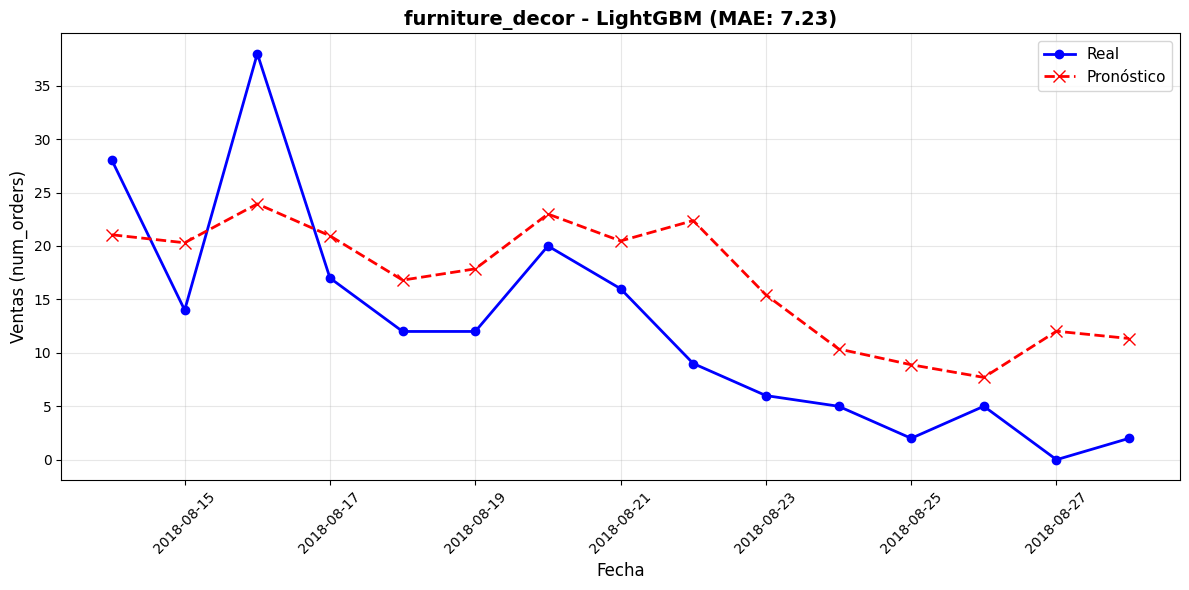

[2/58] Gráfico: luggage_accessories - RandomForest


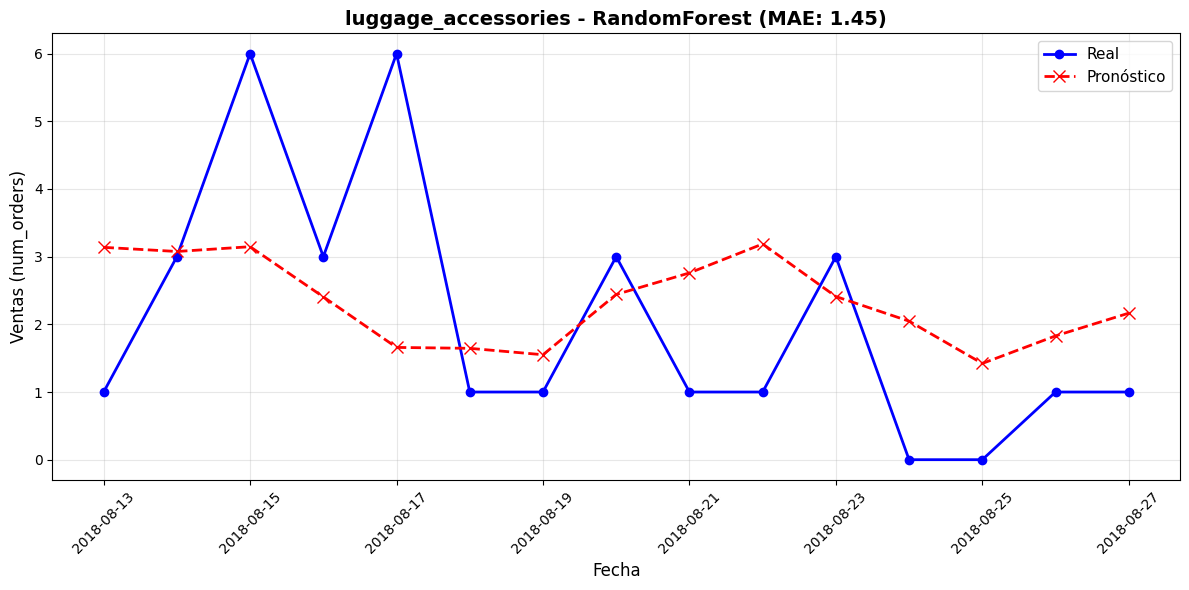

[3/58] Gráfico: stationery - LightGBM


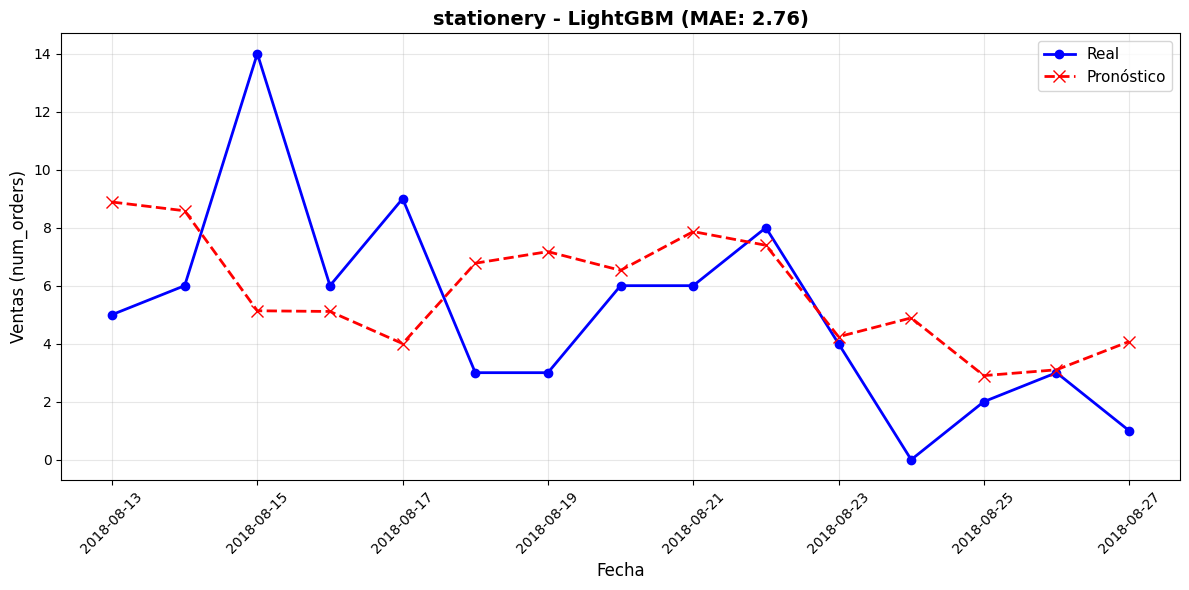

[4/58] Gráfico: home_construction - LightGBM


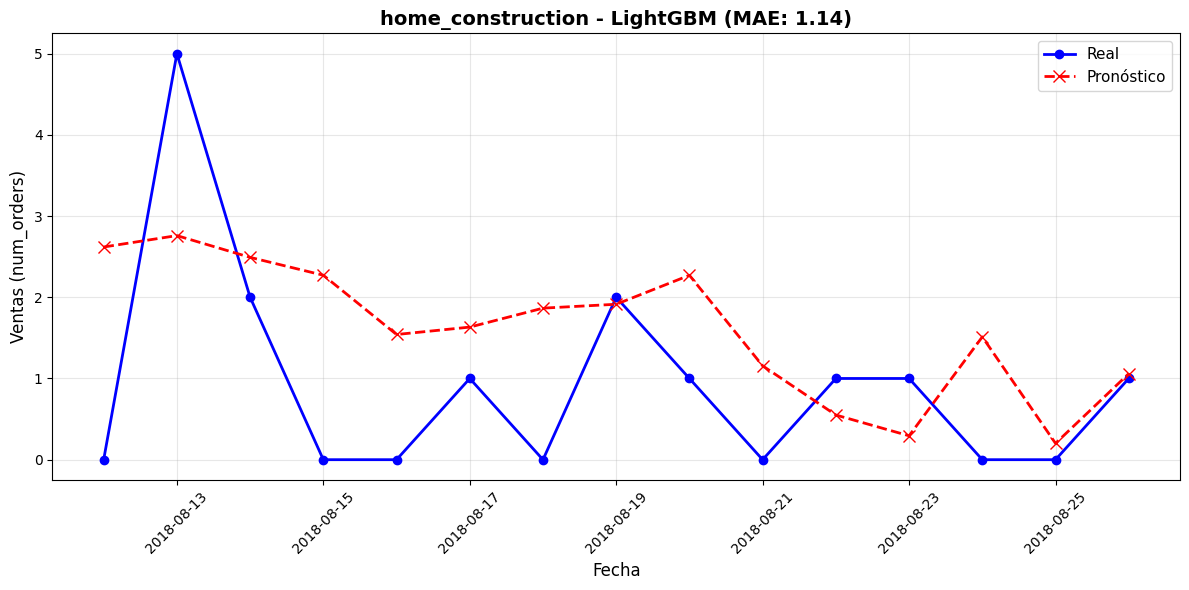

[5/58] Gráfico: home_appliances_2 - LightGBM


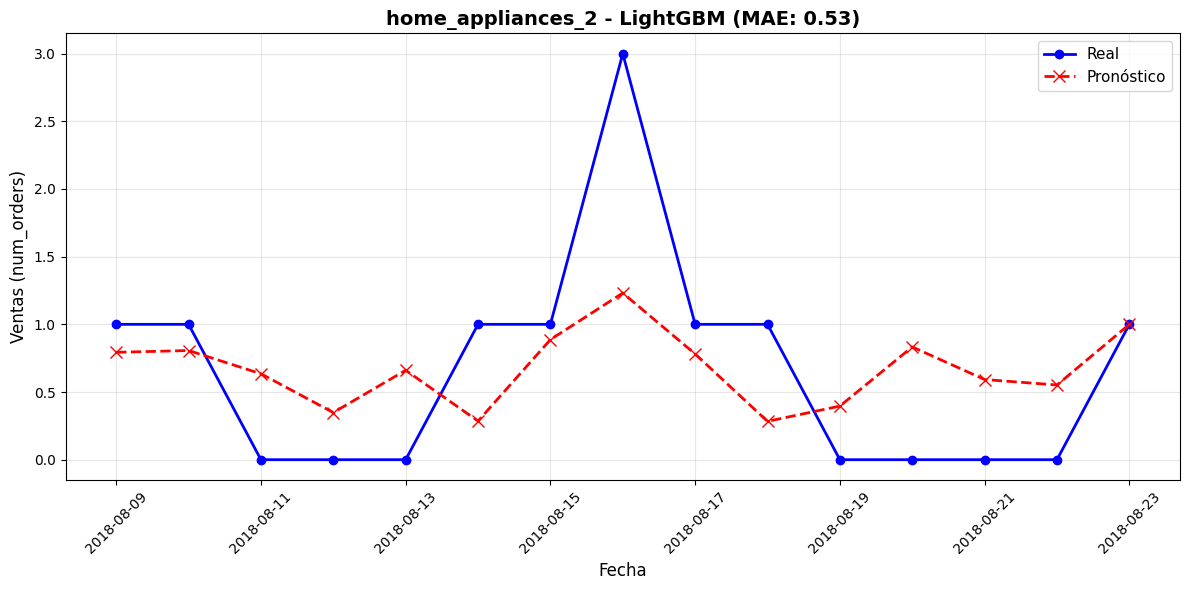

[6/58] Gráfico: construction_tools_safety - RandomForest


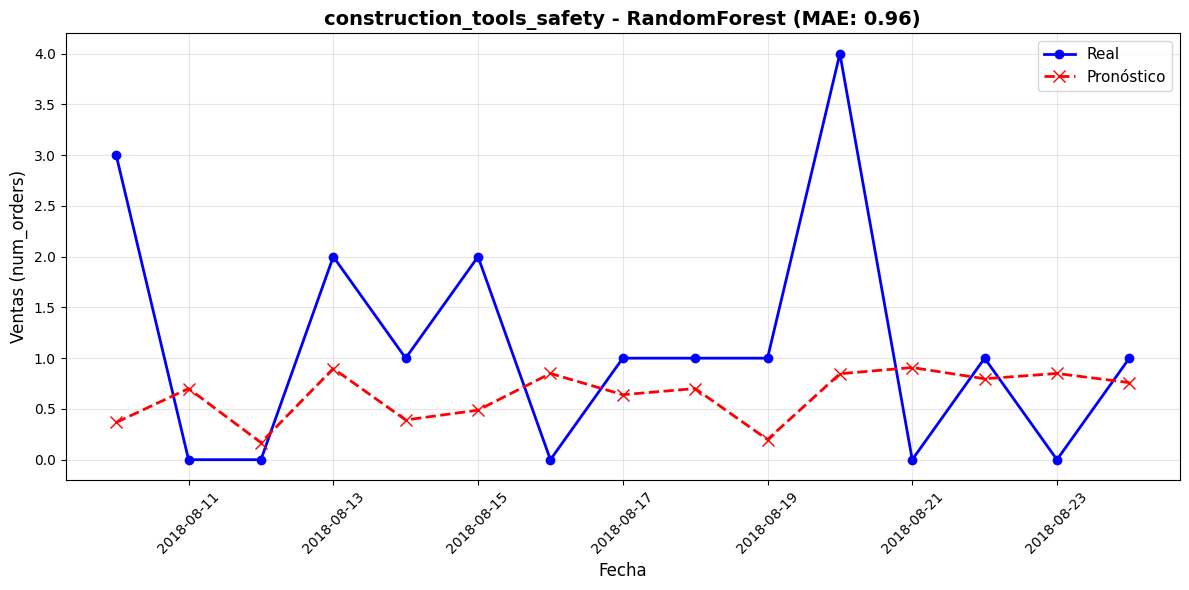

[7/58] Gráfico: drinks - RandomForest


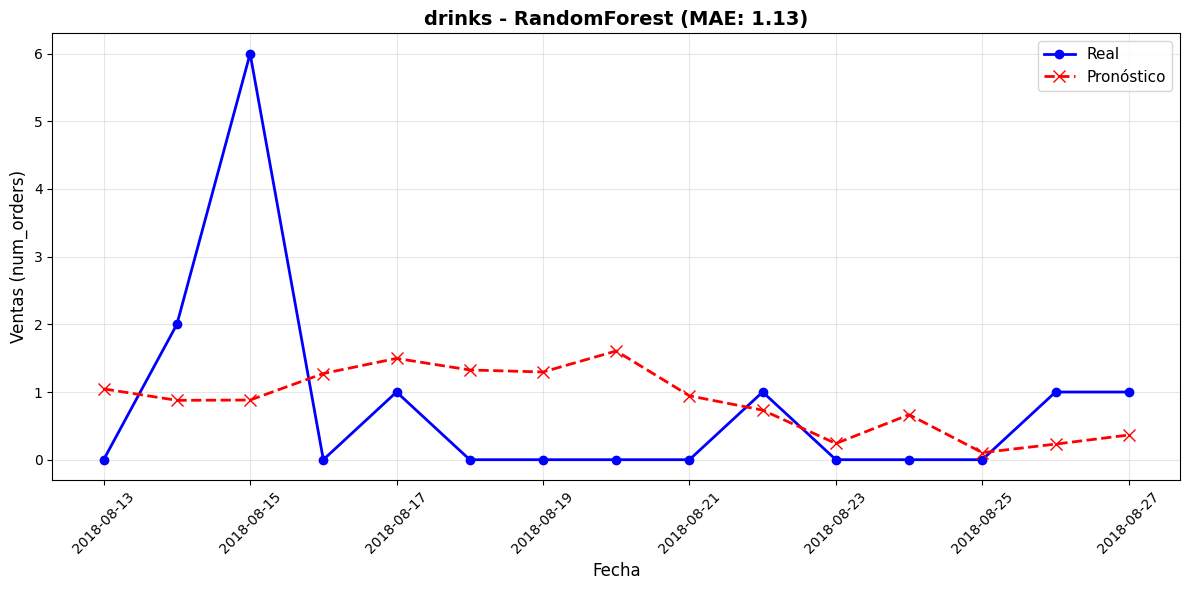

[8/58] Gráfico: consoles_games - XGBoost


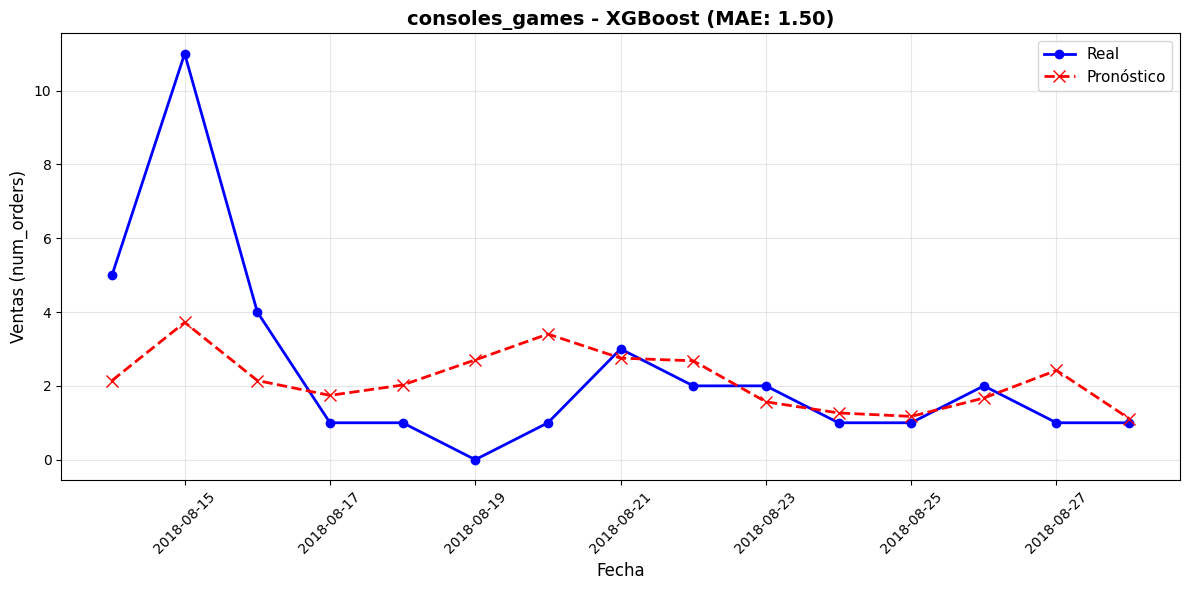

[9/58] Gráfico: kitchen_dining_laundry_garden_furniture - RandomForest


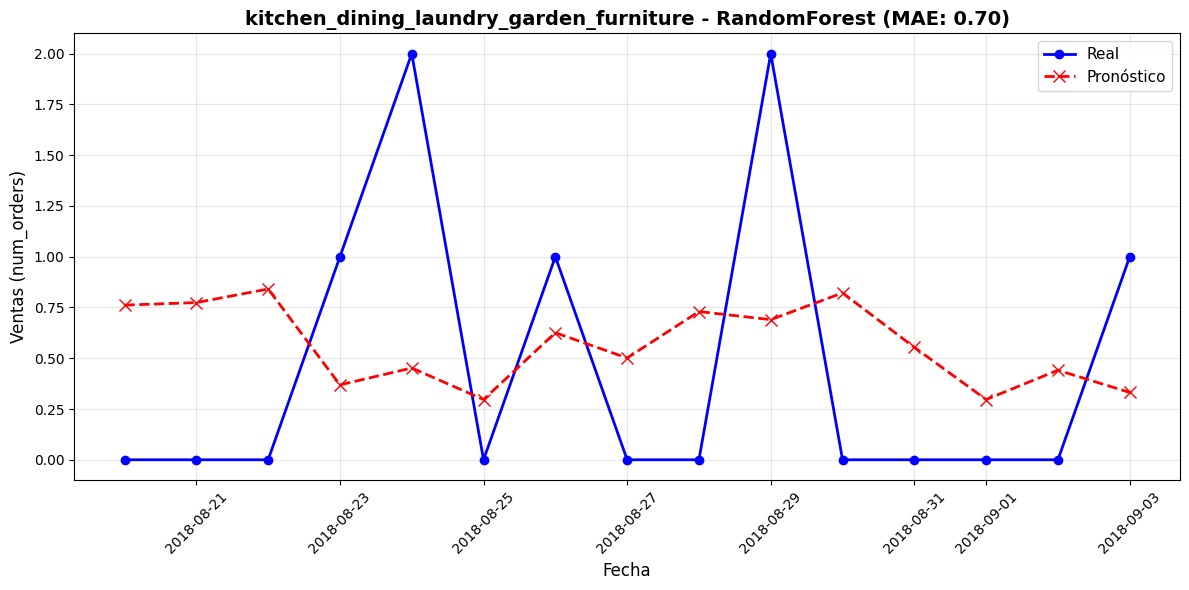

[10/58] Gráfico: industry_commerce_and_business - RandomForest


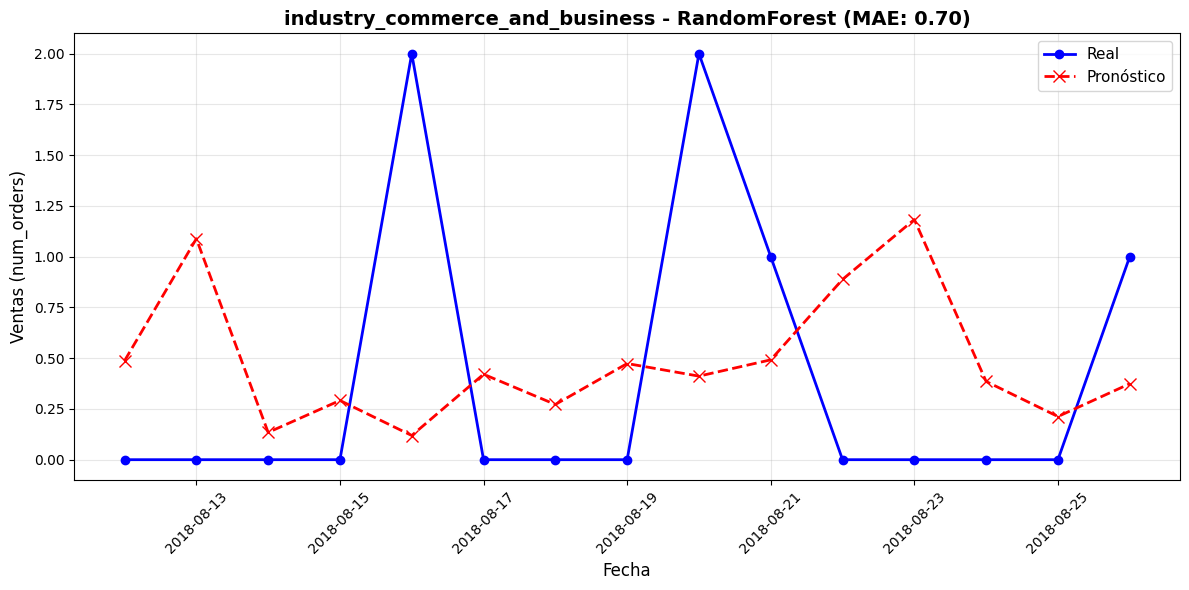

[11/58] Gráfico: fixed_telephony - LightGBM


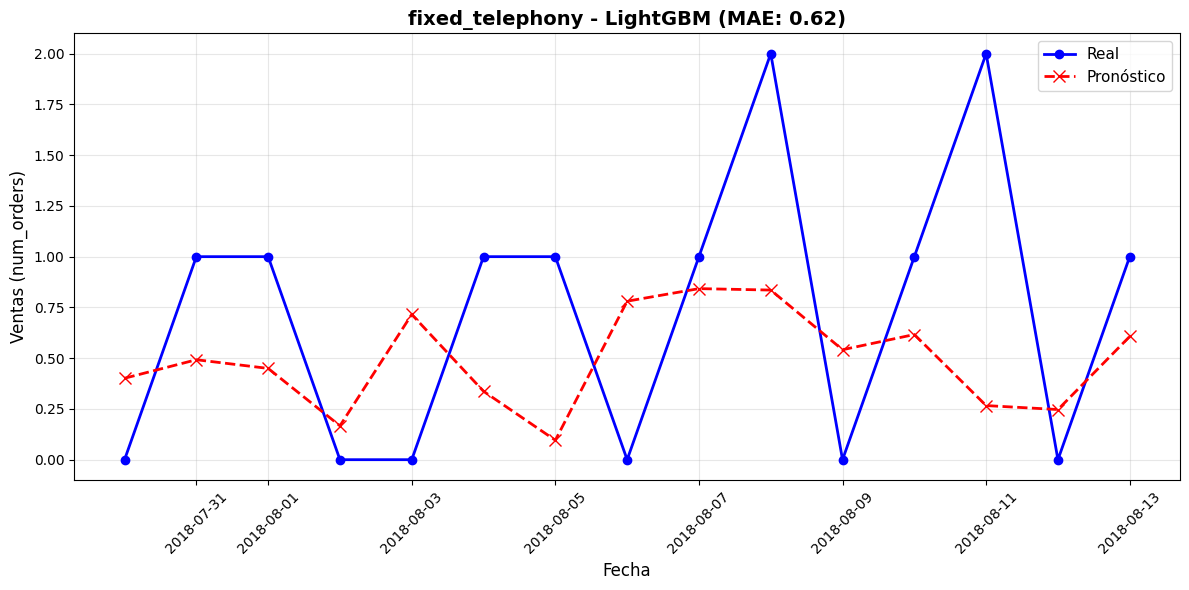

[12/58] Gráfico: fashion_male_clothing - RandomForest


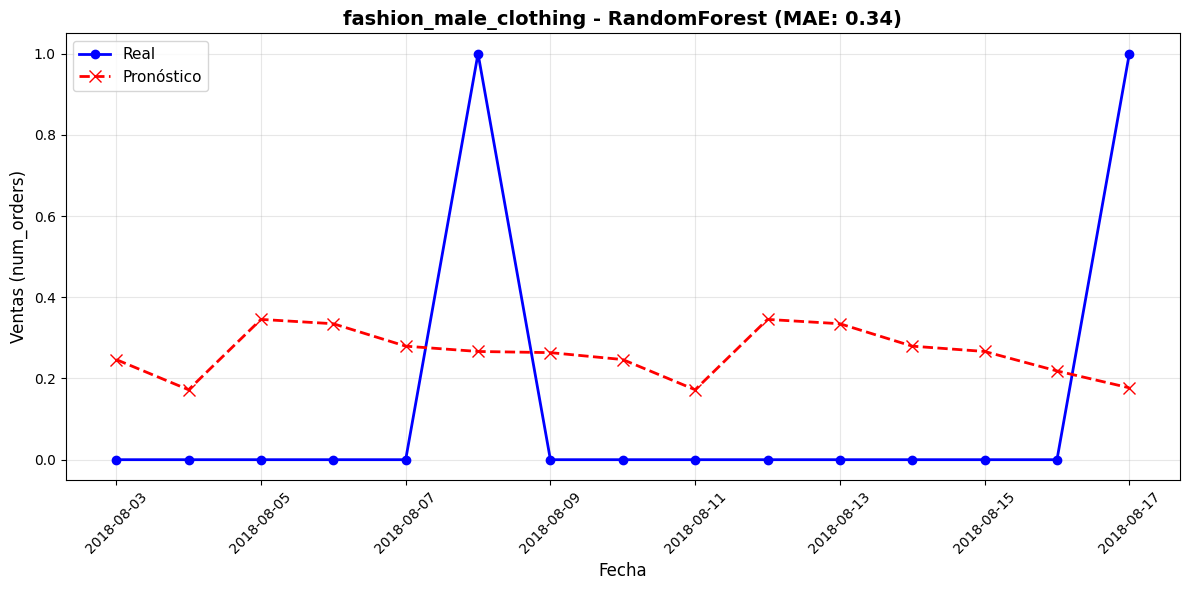

[13/58] Gráfico: perfumery - RandomForest


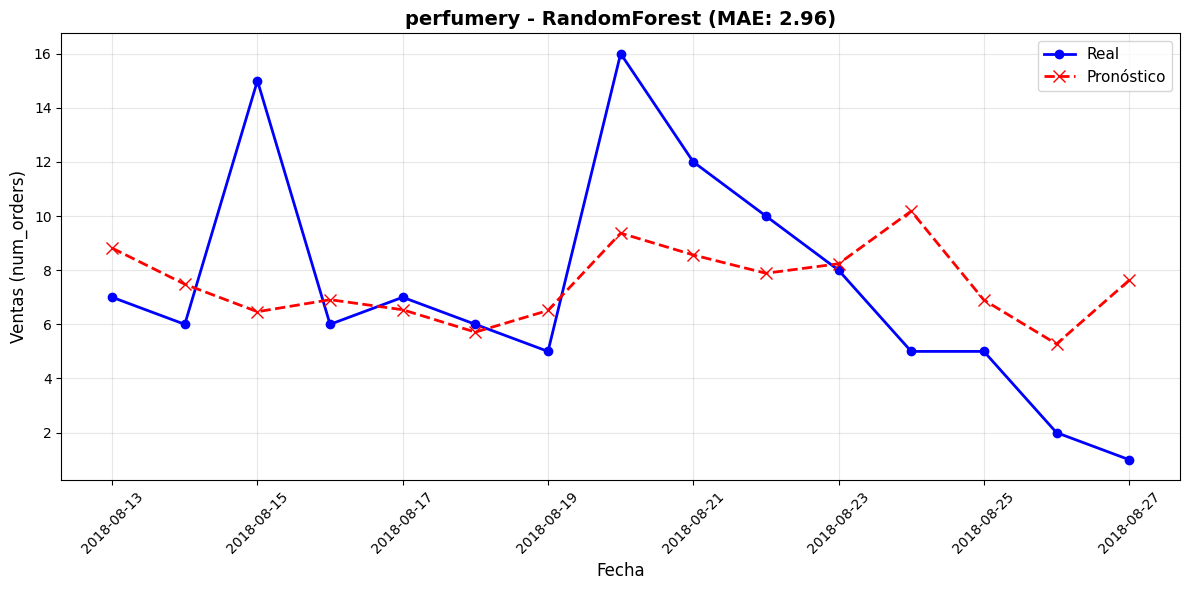

[14/58] Gráfico: costruction_tools_garden - LightGBM


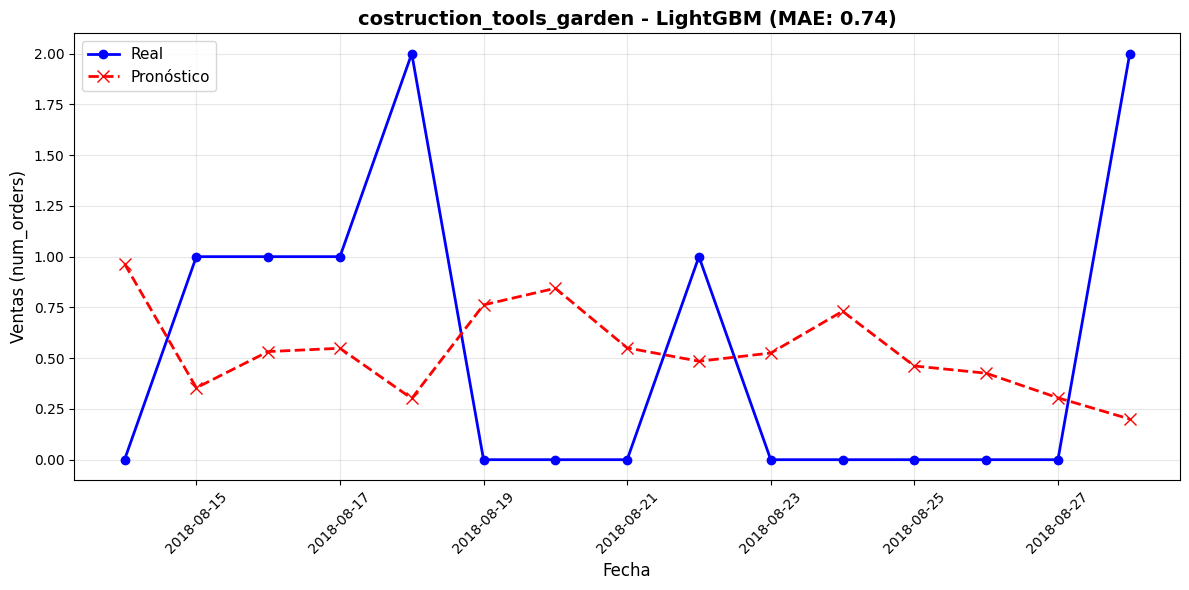

[15/58] Gráfico: art - LightGBM


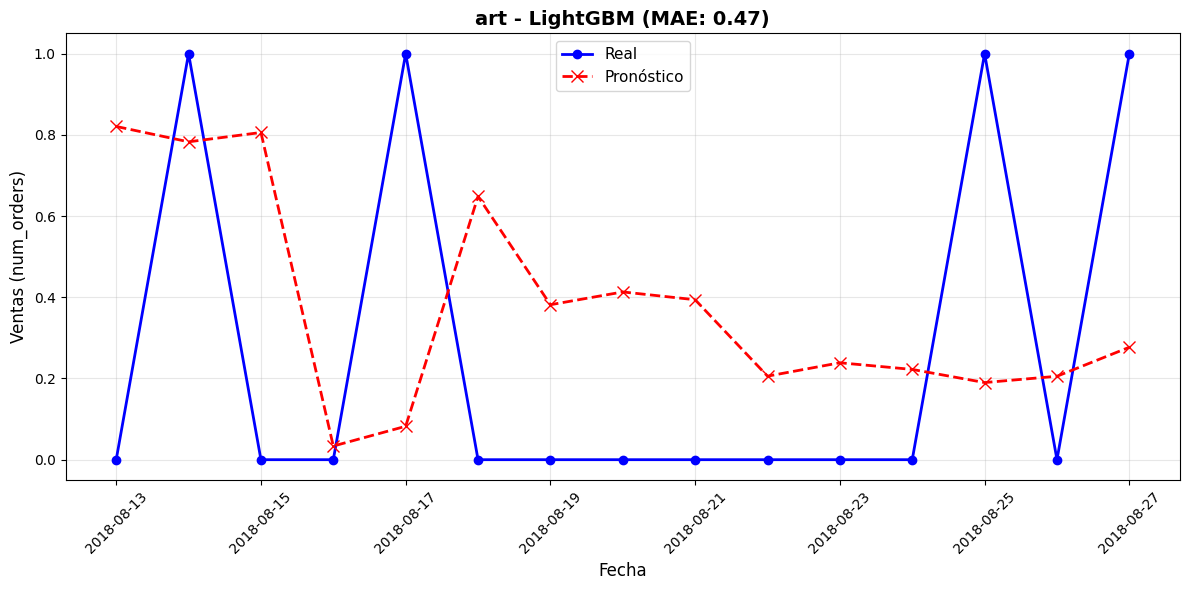

[16/58] Gráfico: christmas_supplies - RandomForest


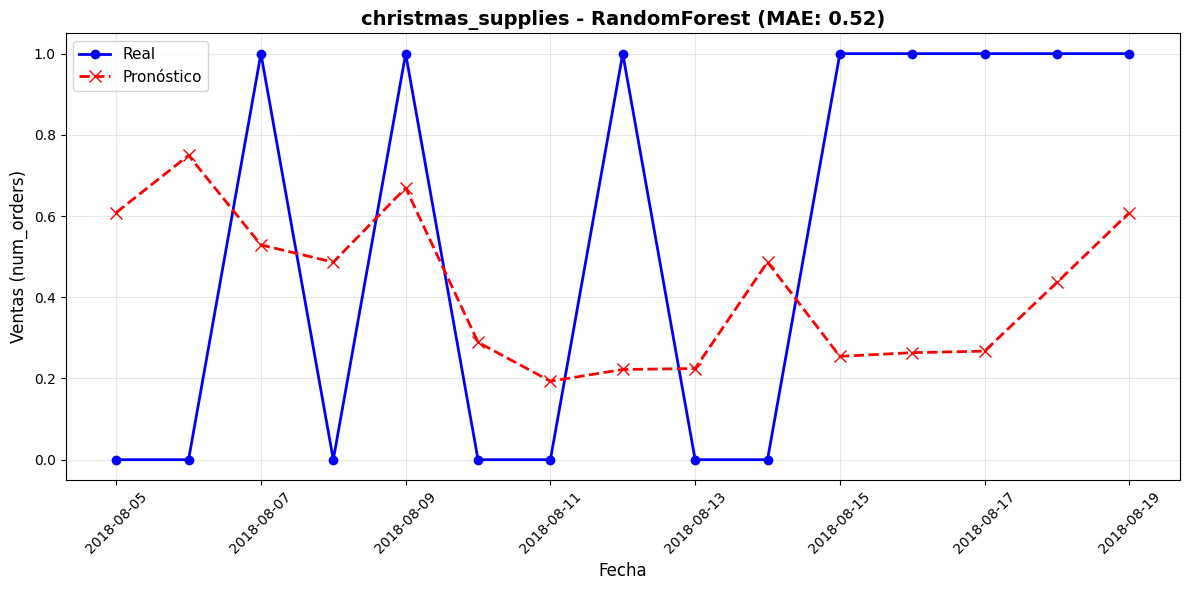

[17/58] Gráfico: furniture_living_room - RandomForest


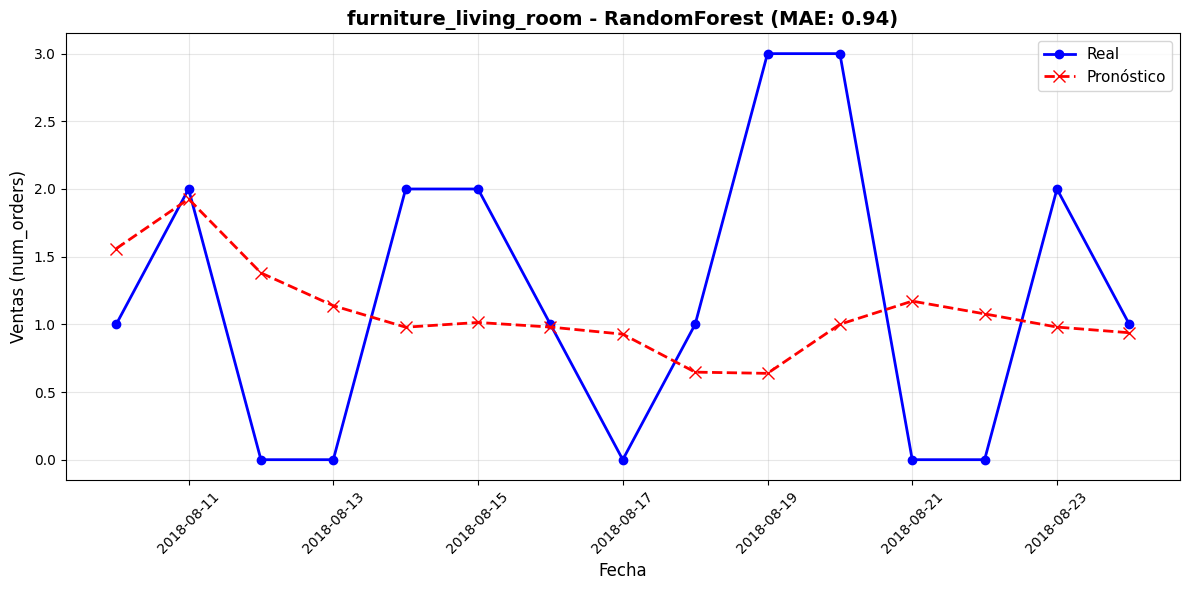

[18/58] Gráfico: construction_tools_lights - LightGBM


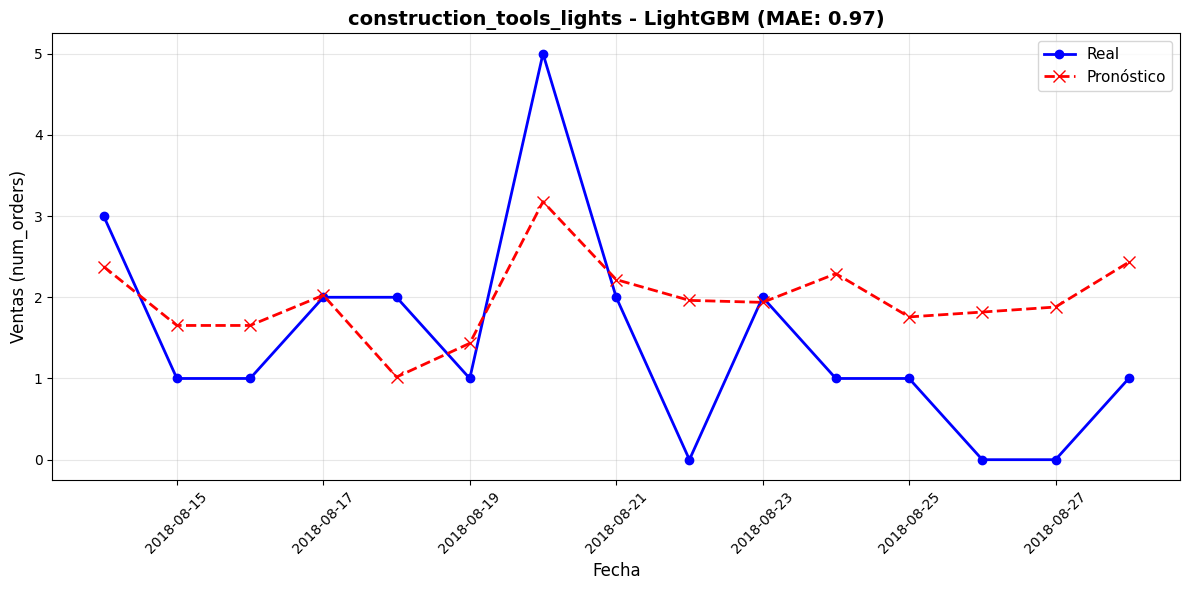

[19/58] Gráfico: tablets_printing_image - RandomForest


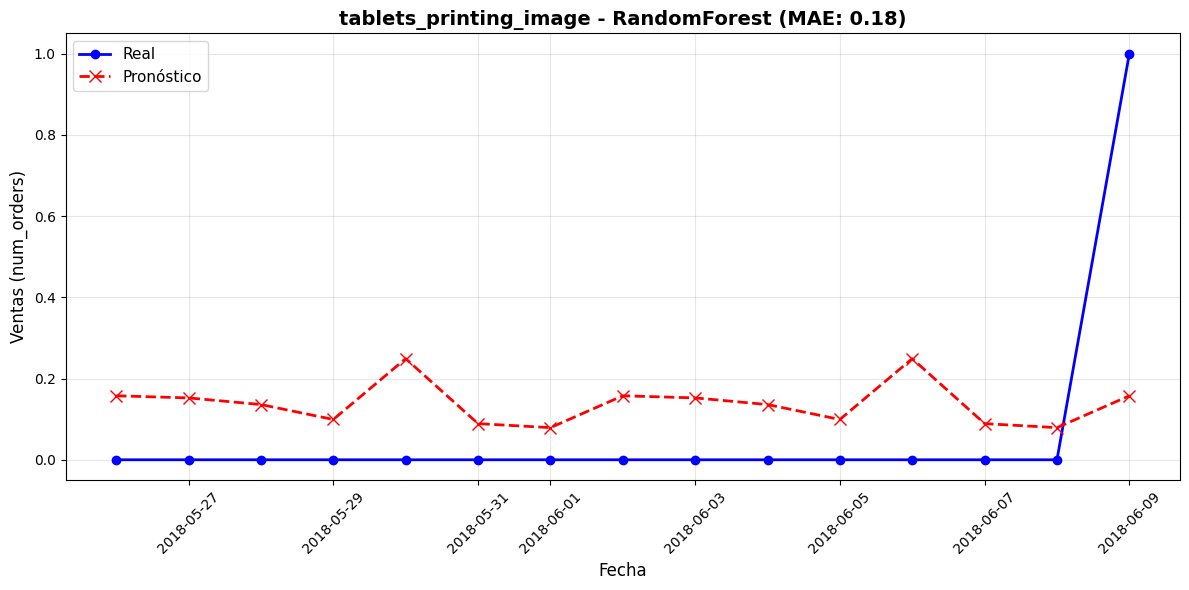

[20/58] Gráfico: auto - LightGBM


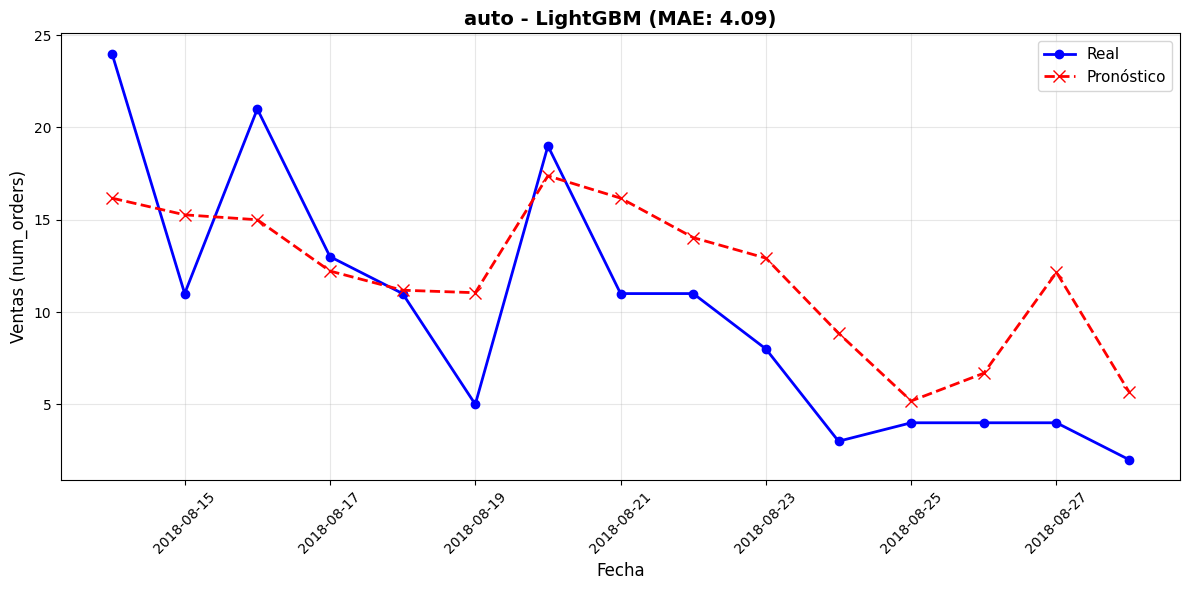

[21/58] Gráfico: air_conditioning - LightGBM


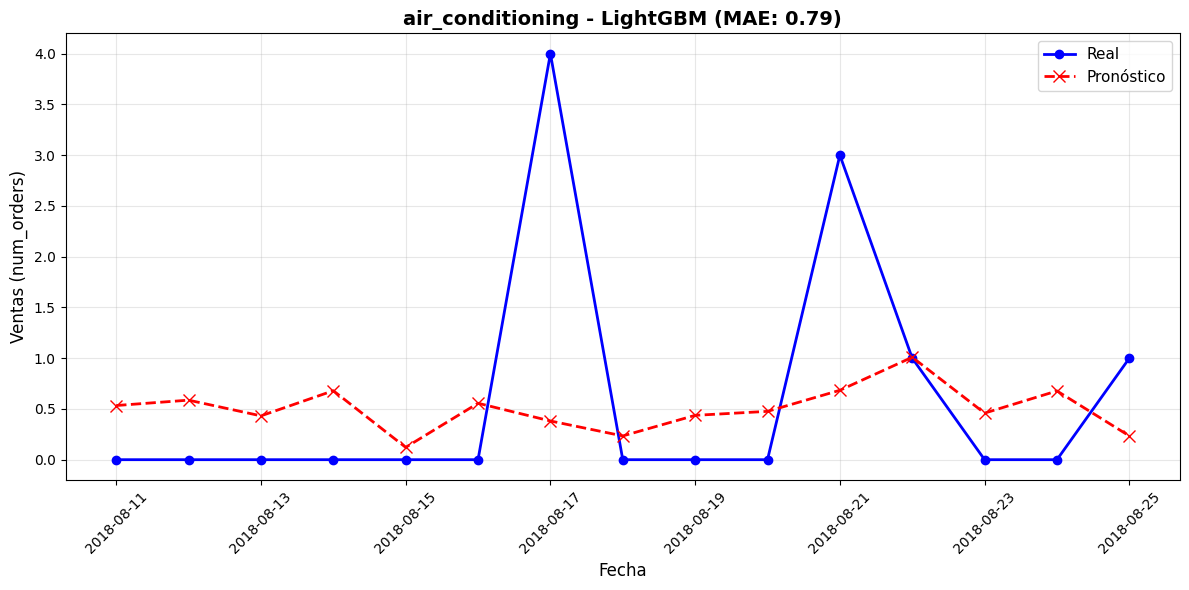

[22/58] Gráfico: fashion_underwear_beach - LightGBM


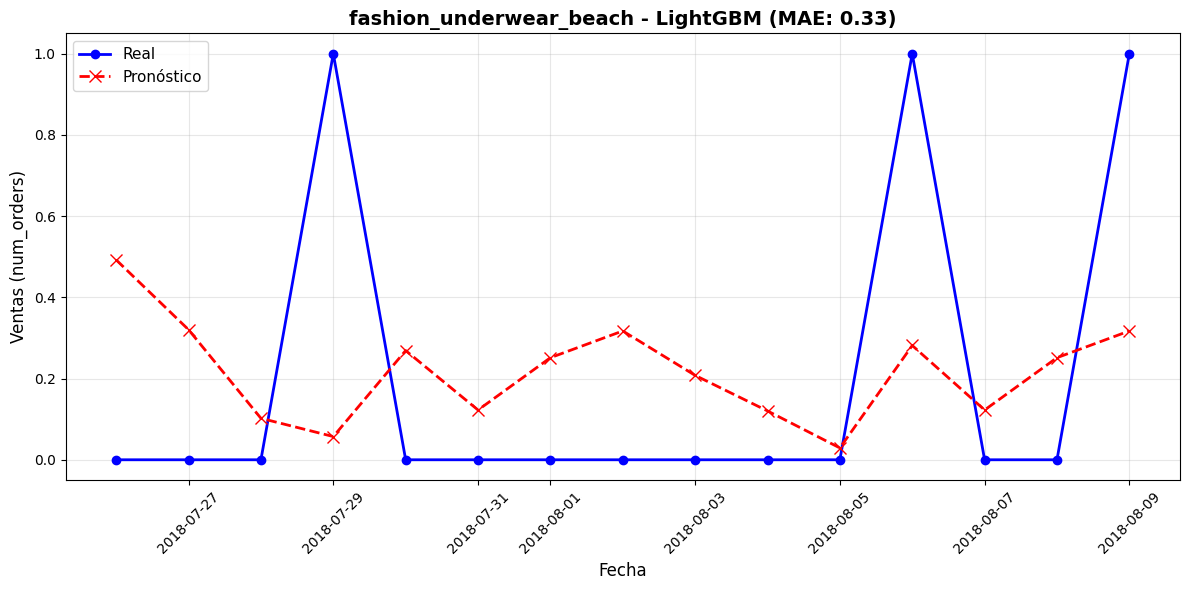

[23/58] Gráfico: dvds_blu_ray - GradientBoosting


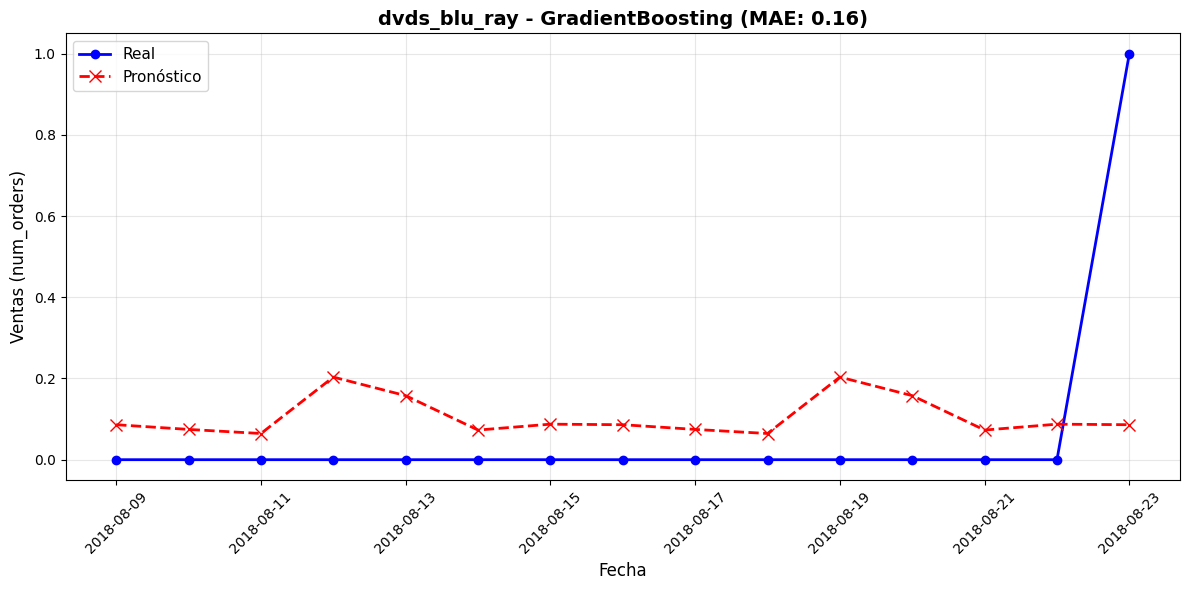

[24/58] Gráfico: books_imported - RandomForest


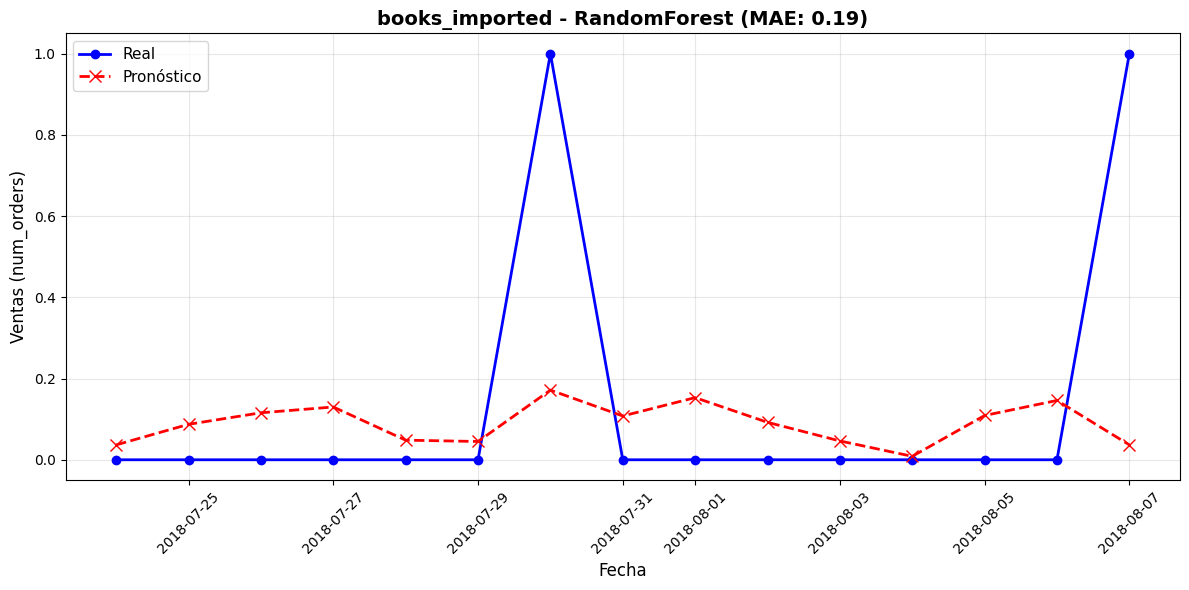

[25/58] Gráfico: books_technical - RandomForest


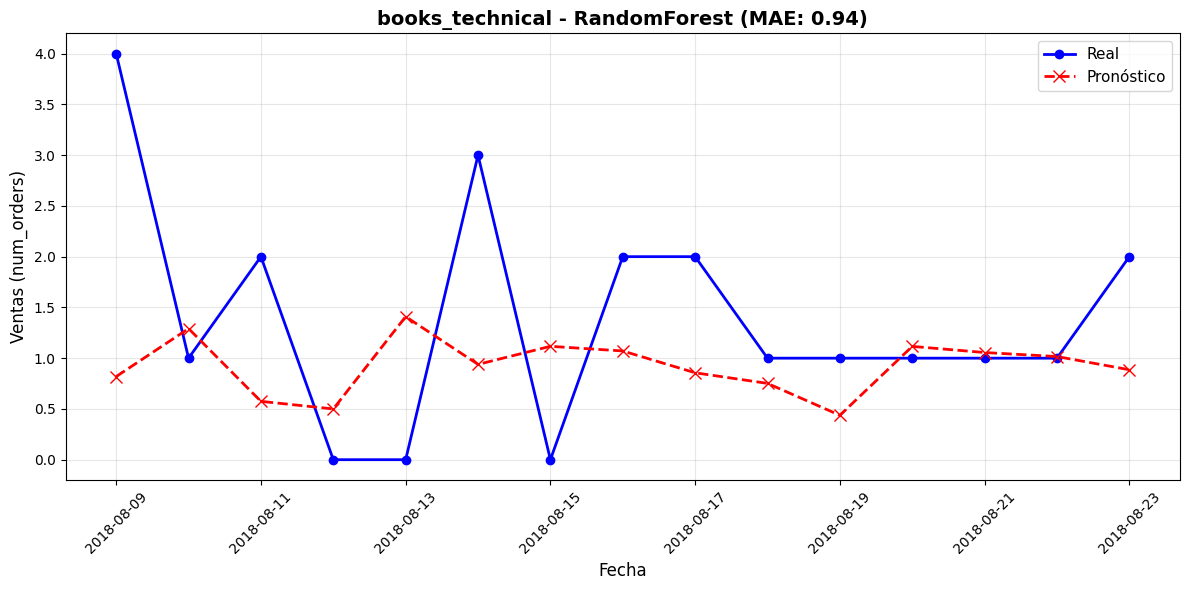

[26/58] Gráfico: fashion_shoes - GradientBoosting


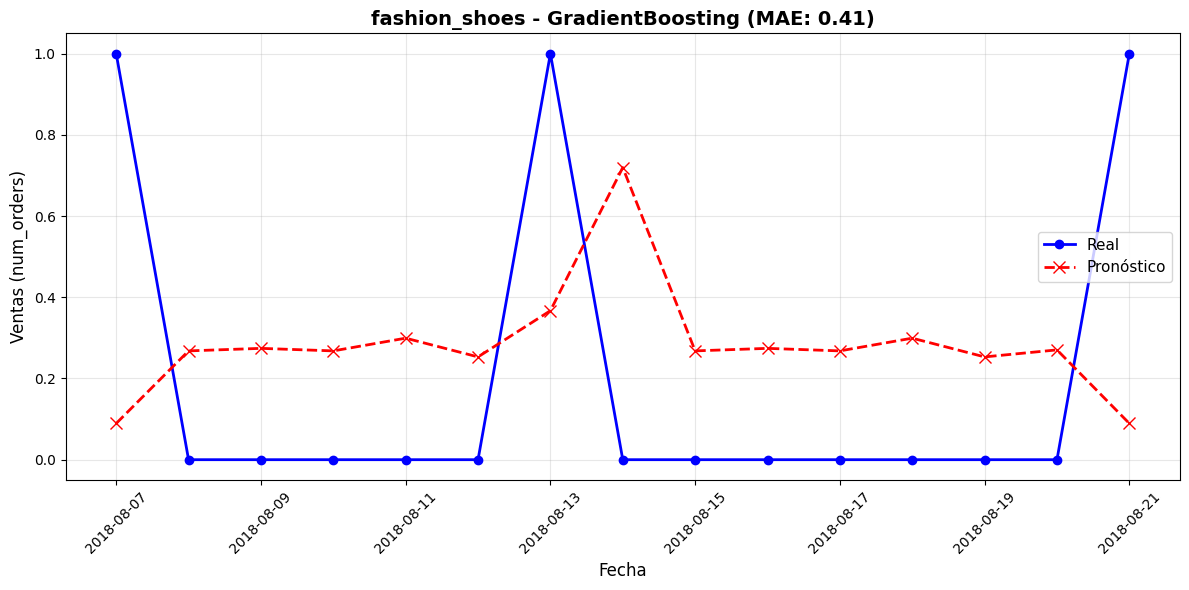

[27/58] Gráfico: costruction_tools_tools - GradientBoosting


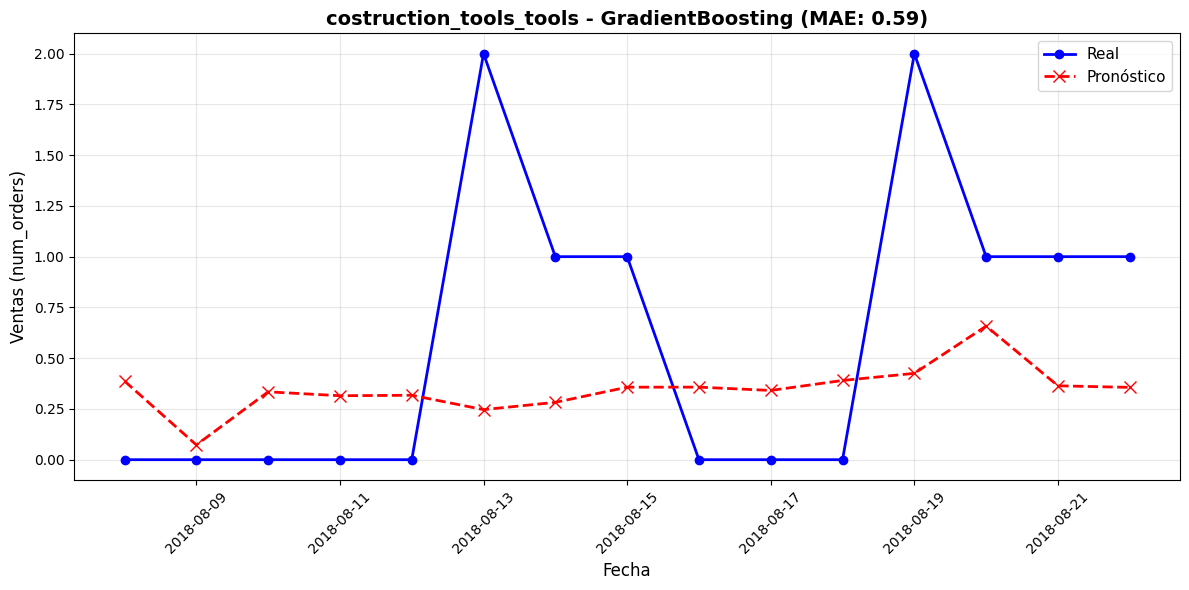

[28/58] Gráfico: office_furniture - LightGBM


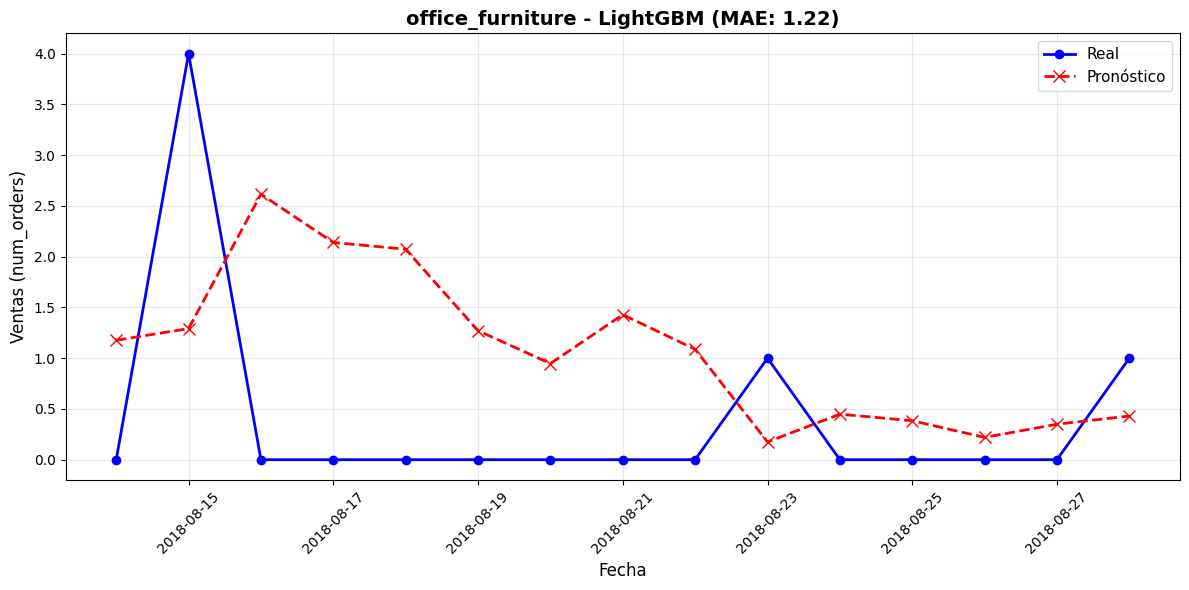

[29/58] Gráfico: market_place - RandomForest


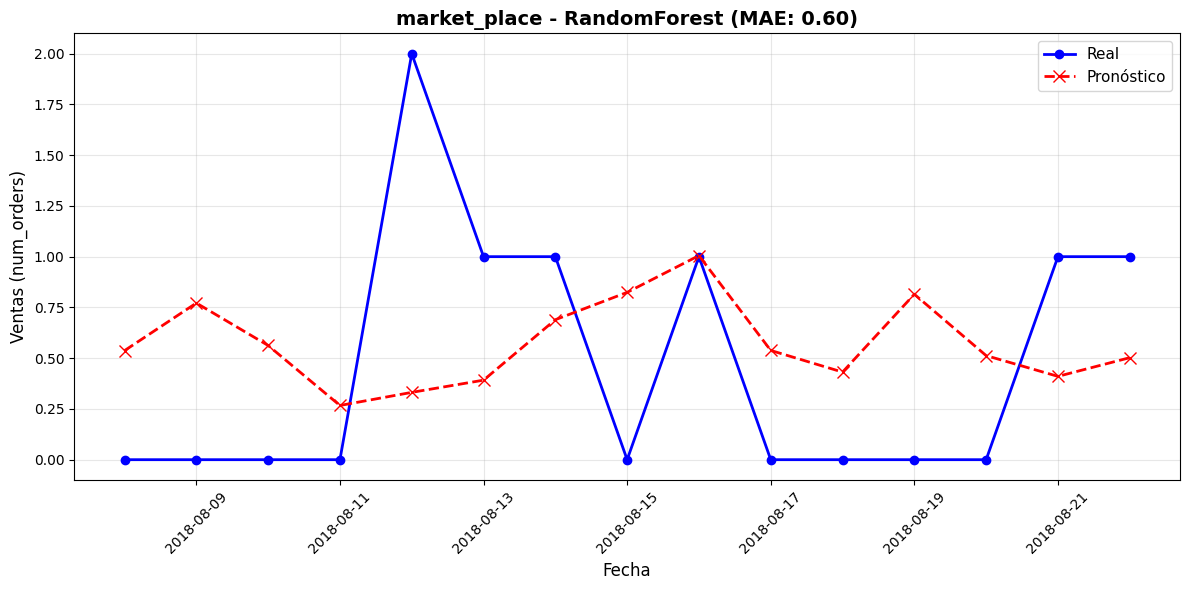

[30/58] Gráfico: cine_photo - LightGBM


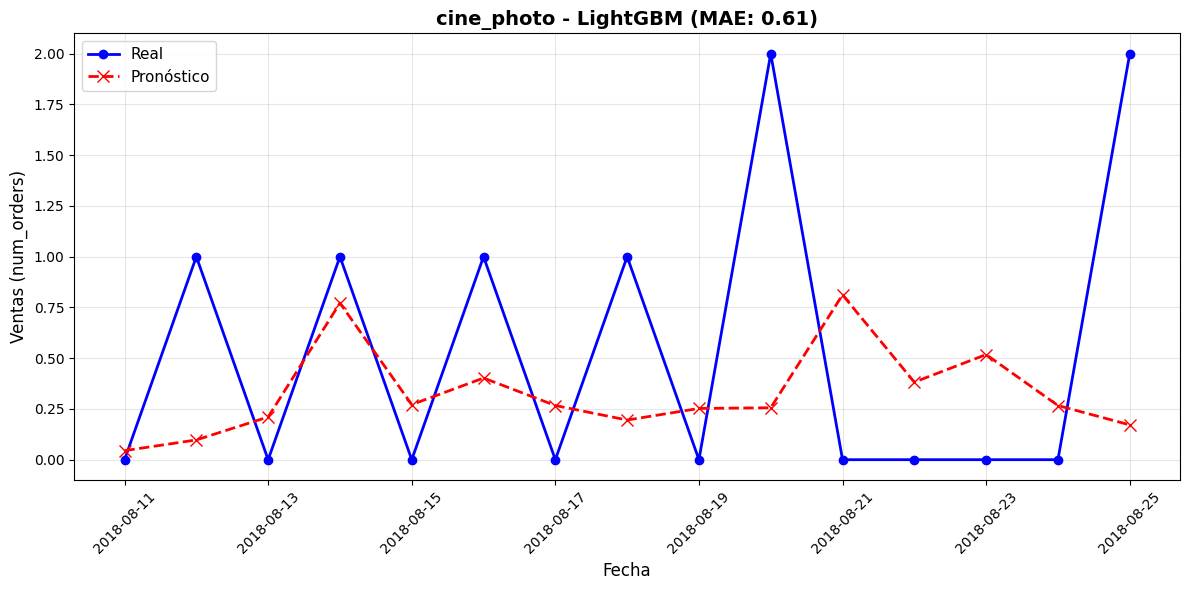

[31/58] Gráfico: pet_shop - GradientBoosting


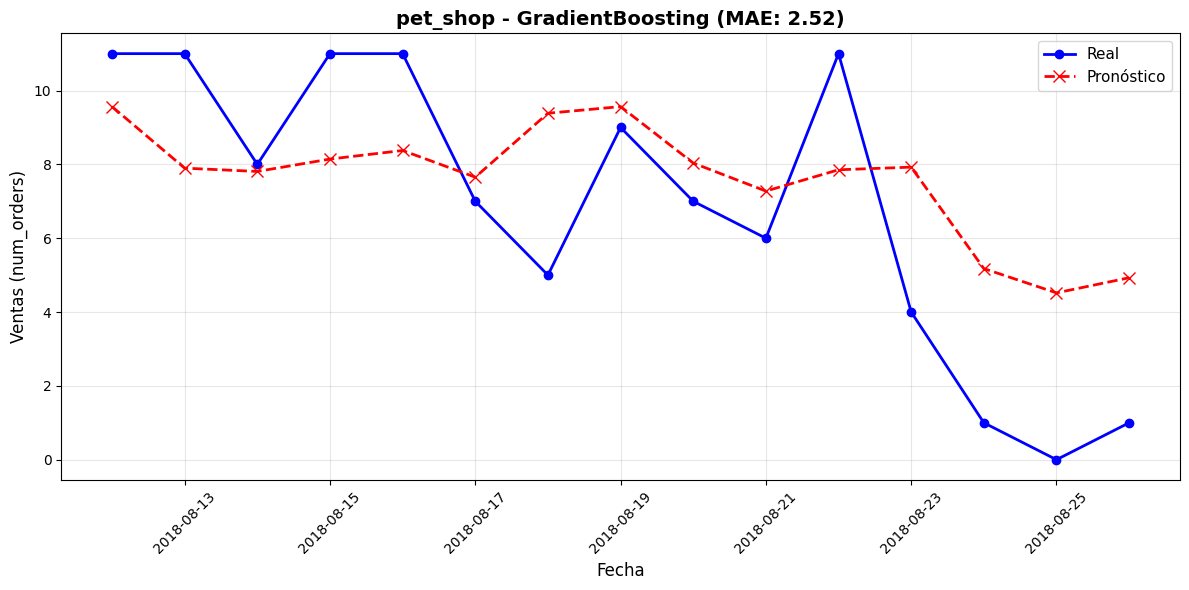

[32/58] Gráfico: small_appliances - RandomForest


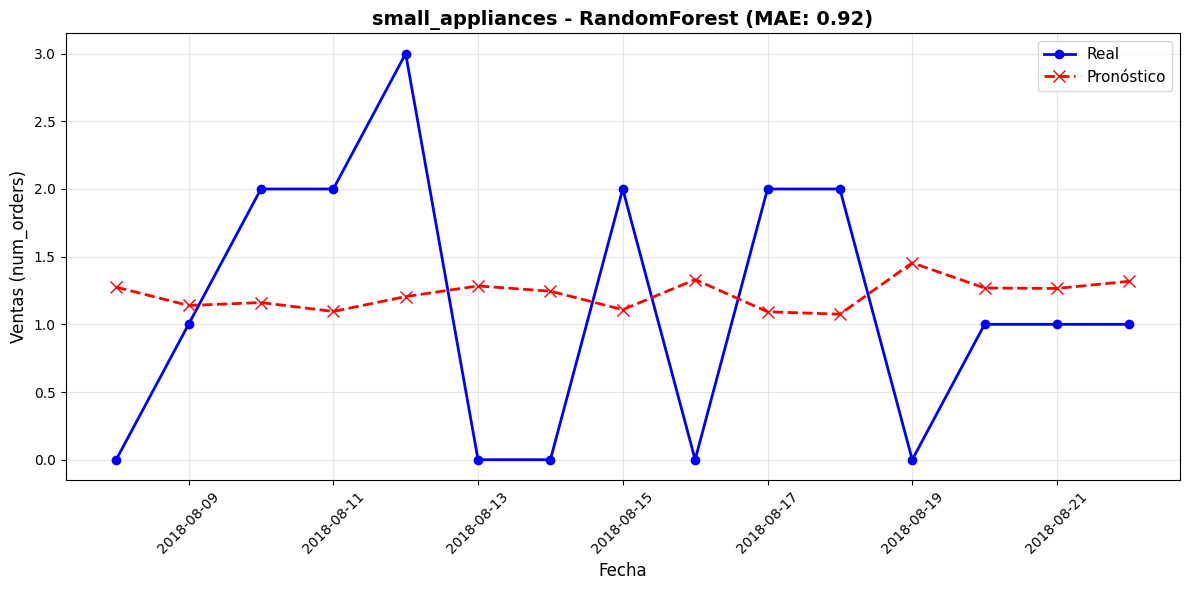

[33/58] Gráfico: bed_bath_table - XGBoost


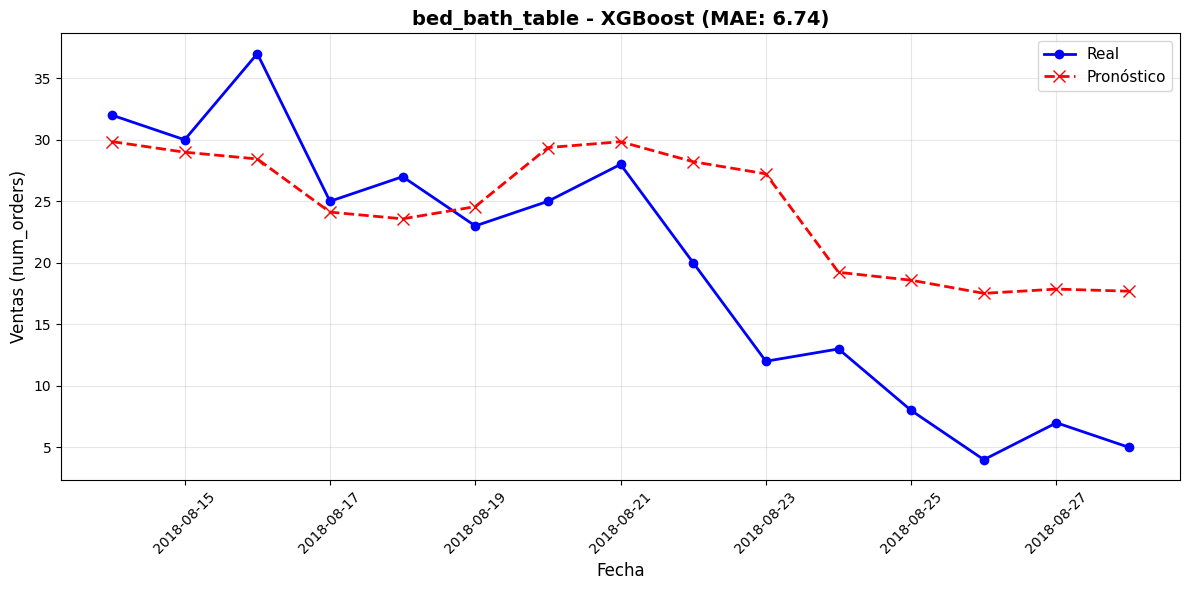

[34/58] Gráfico: agro_industry_and_commerce - LightGBM


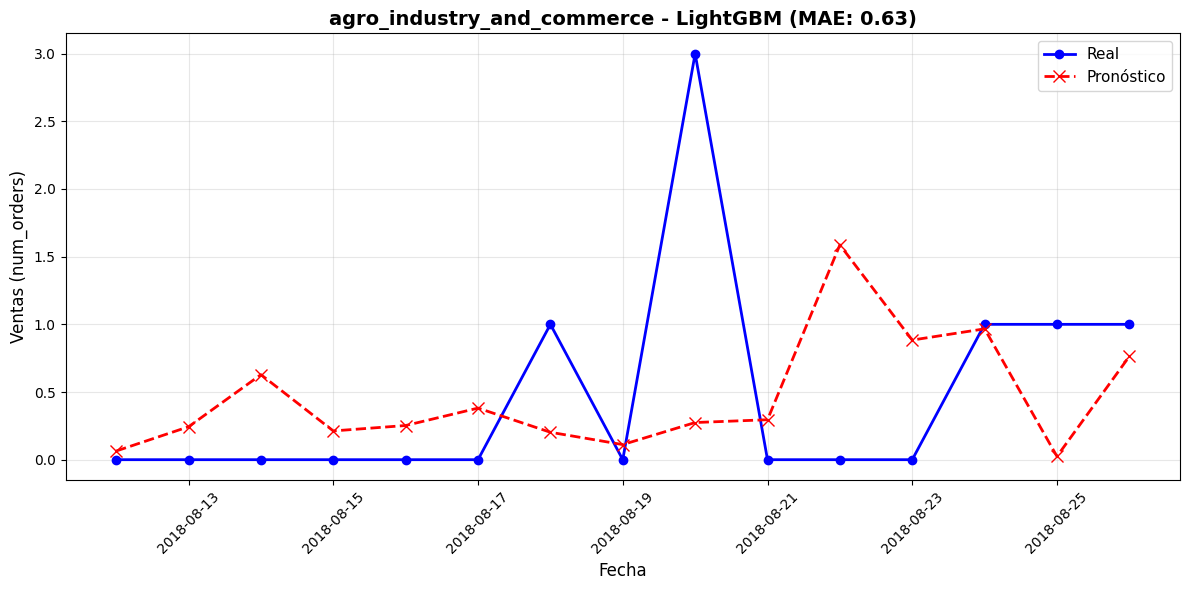

[35/58] Gráfico: small_appliances_home_oven_and_coffee - GradientBoosting


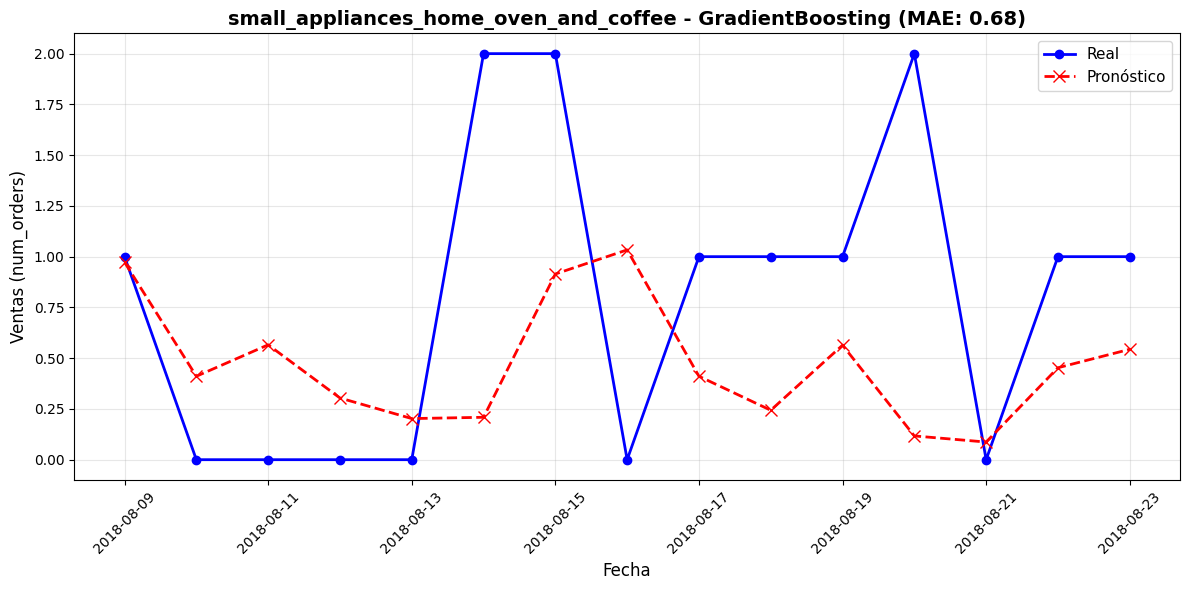

[36/58] Gráfico: books_general_interest - RandomForest


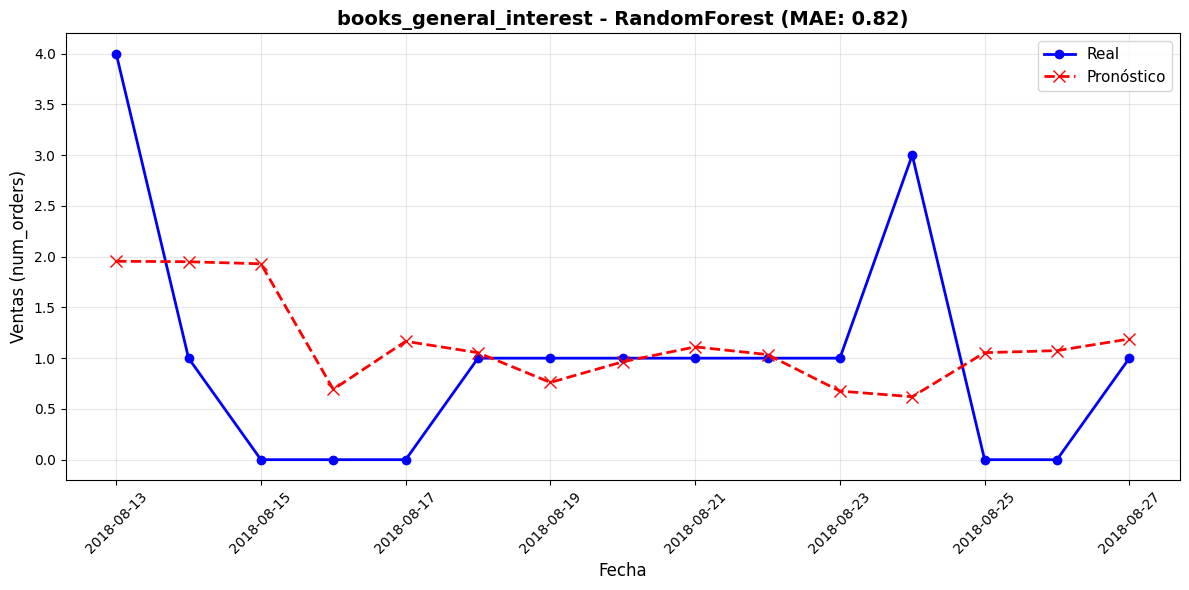

[37/58] Gráfico: signaling_and_security - GradientBoosting


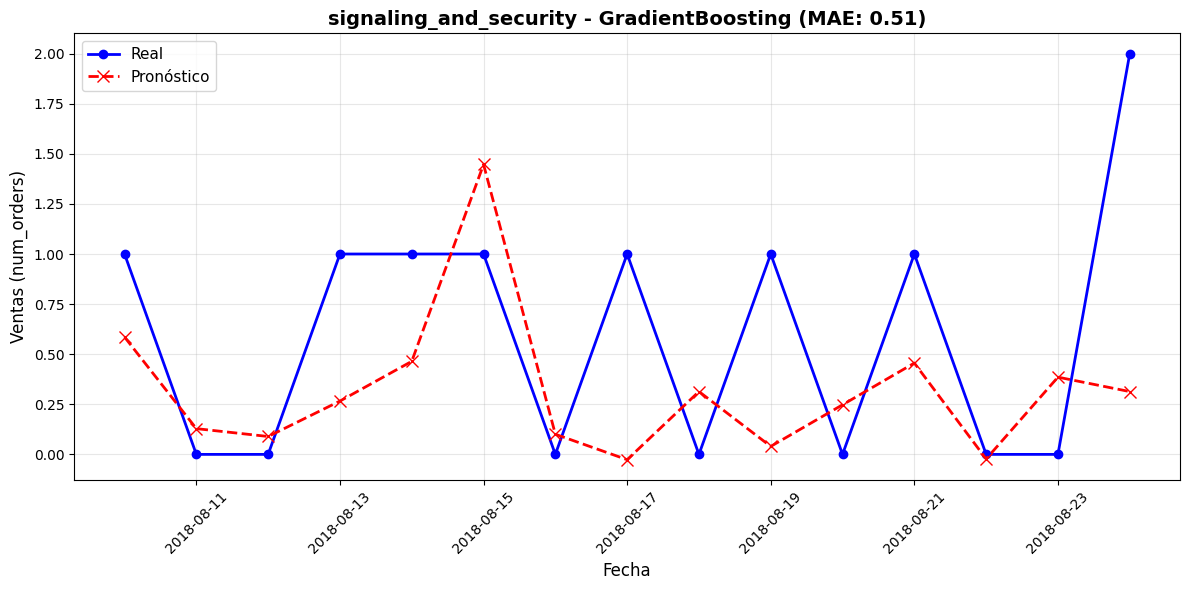

[38/58] Gráfico: computers_accessories - RandomForest


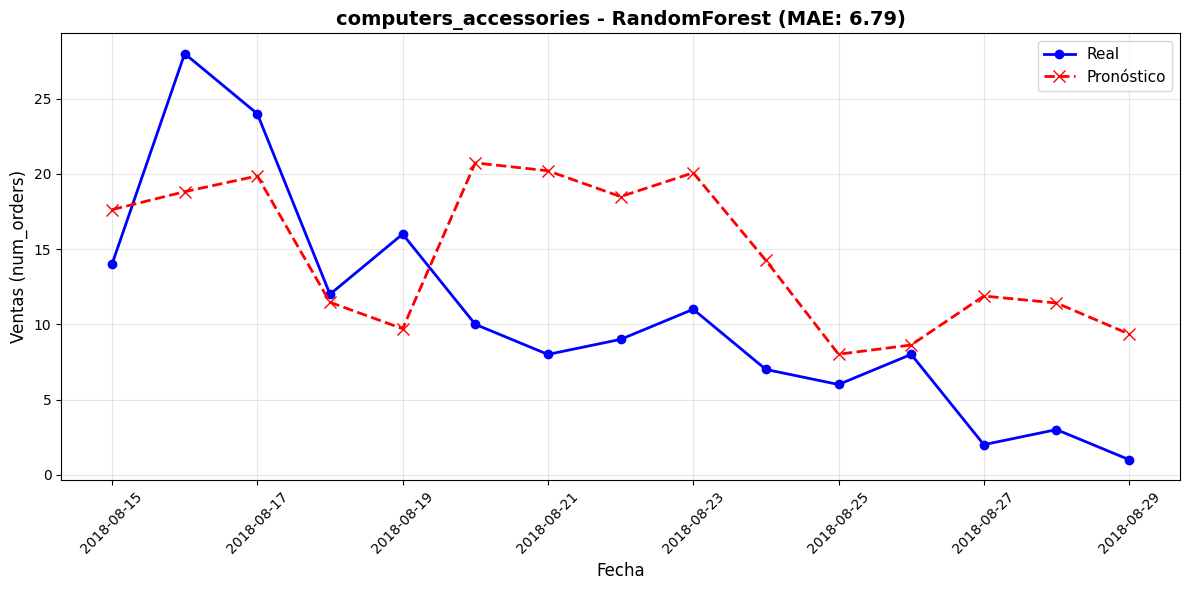

[39/58] Gráfico: food_drink - XGBoost


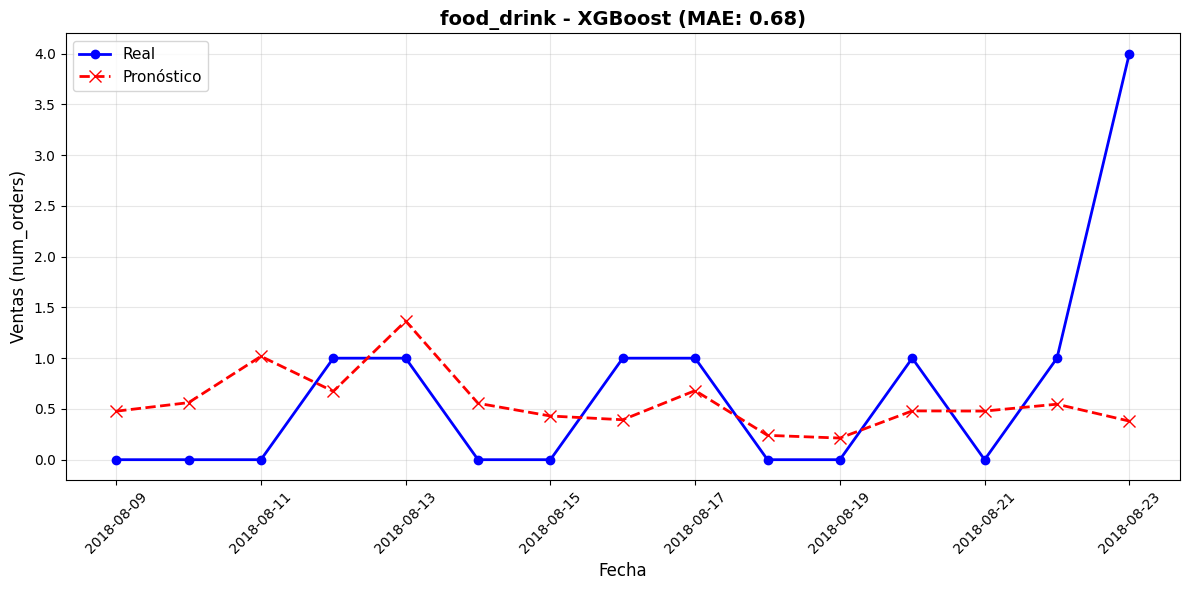

[40/58] Gráfico: computers - GradientBoosting


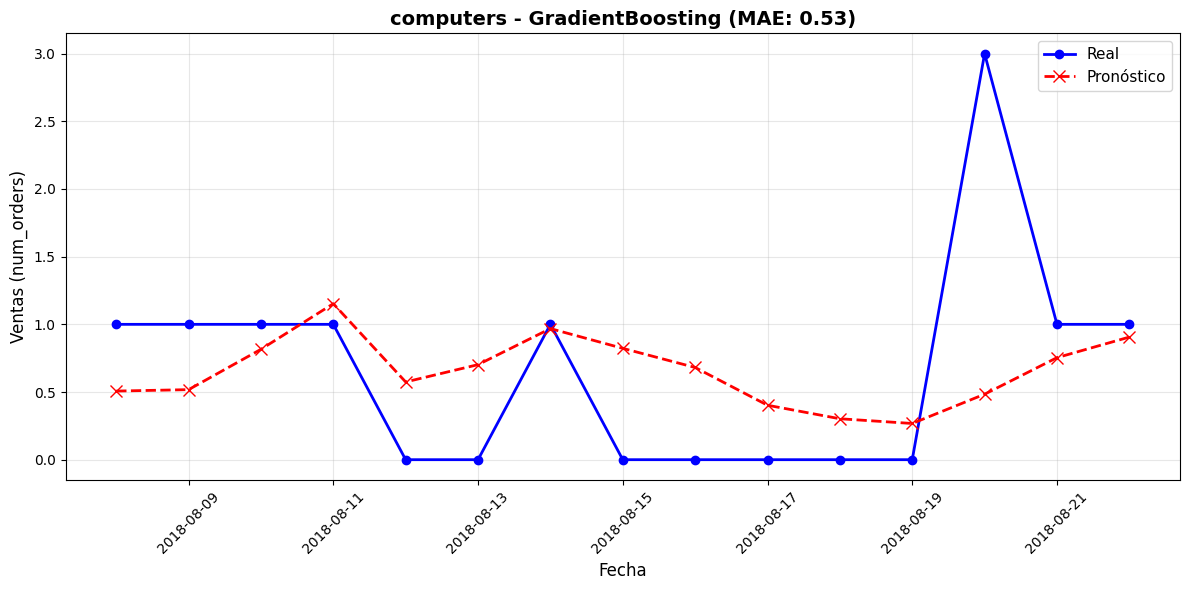

[41/58] Gráfico: audio - GradientBoosting


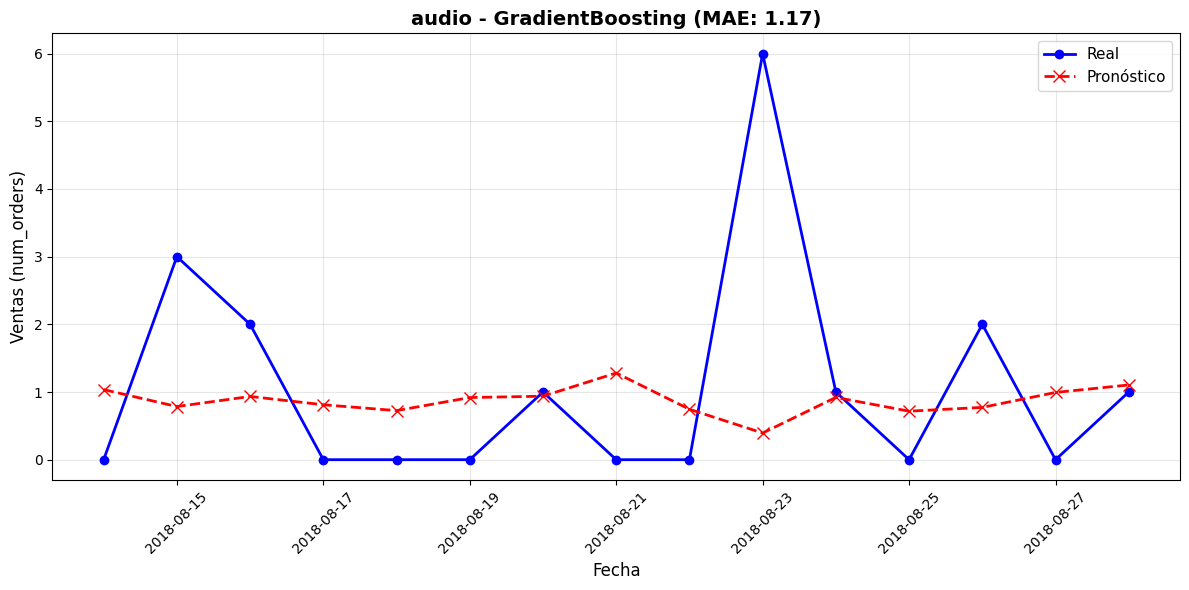

[42/58] Gráfico: home_appliances - RandomForest


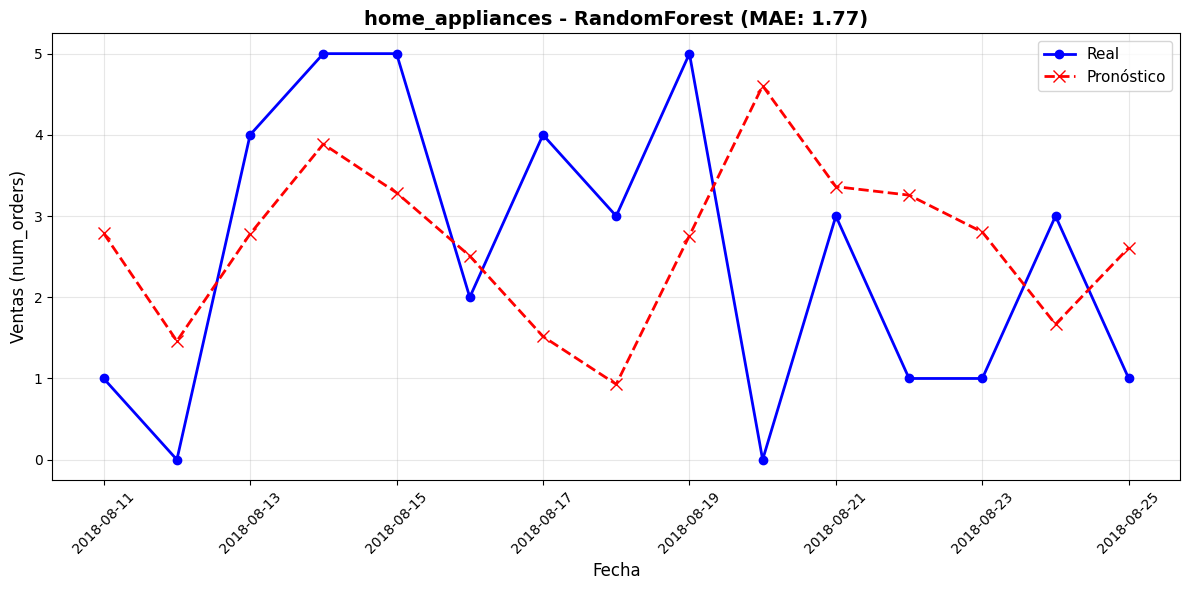

[43/58] Gráfico: musical_instruments - XGBoost


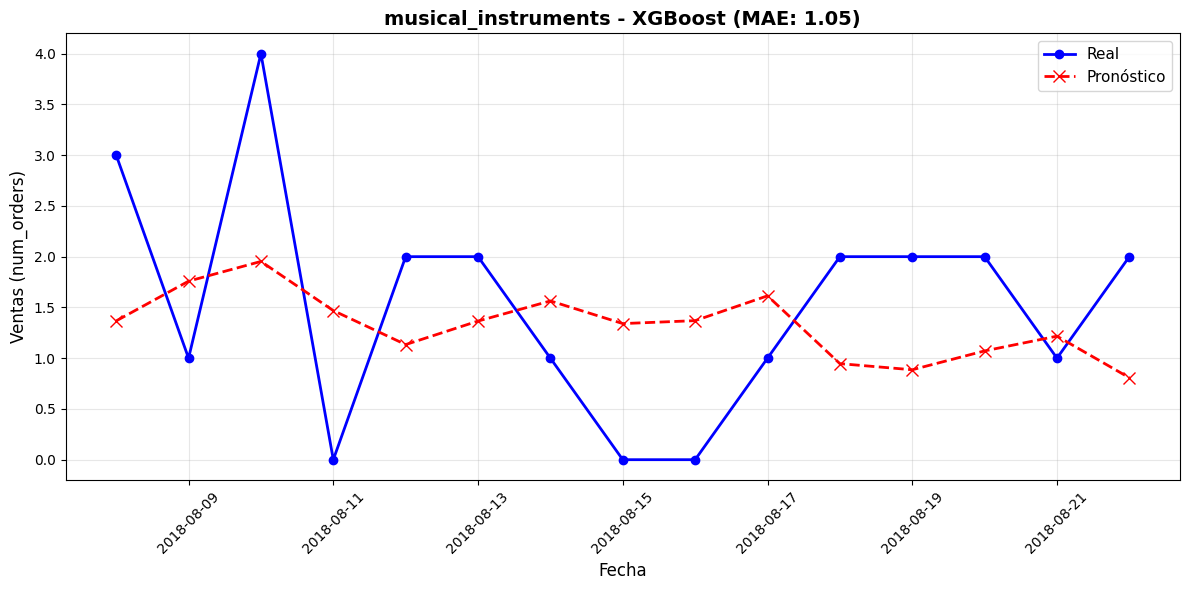

[44/58] Gráfico: fashion_bags_accessories - XGBoost


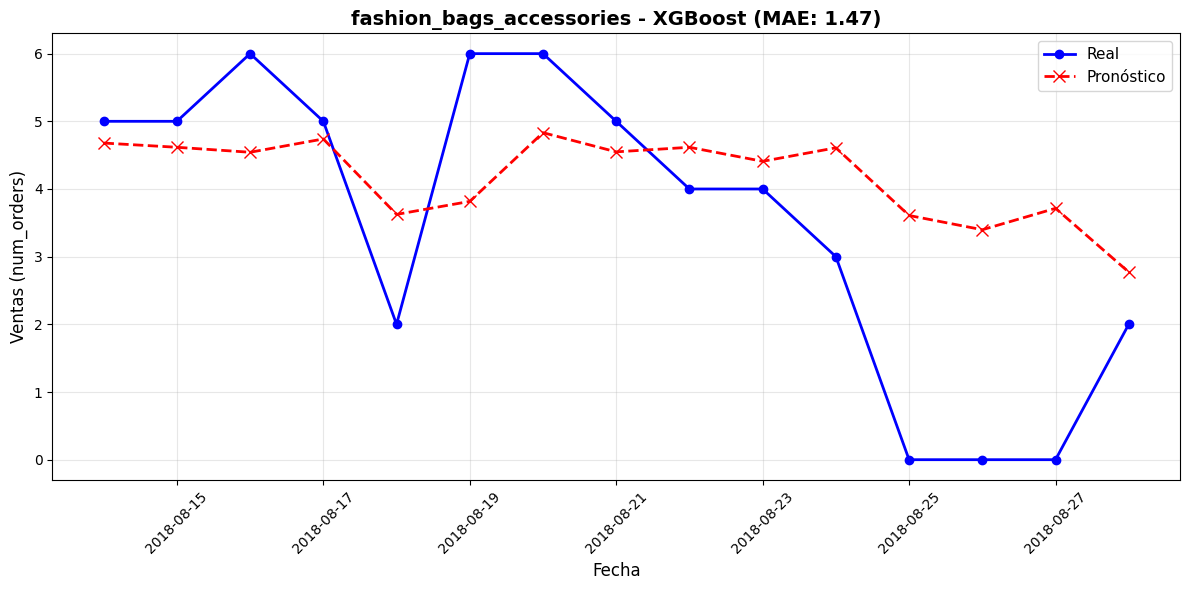

[45/58] Gráfico: construction_tools_construction - LightGBM


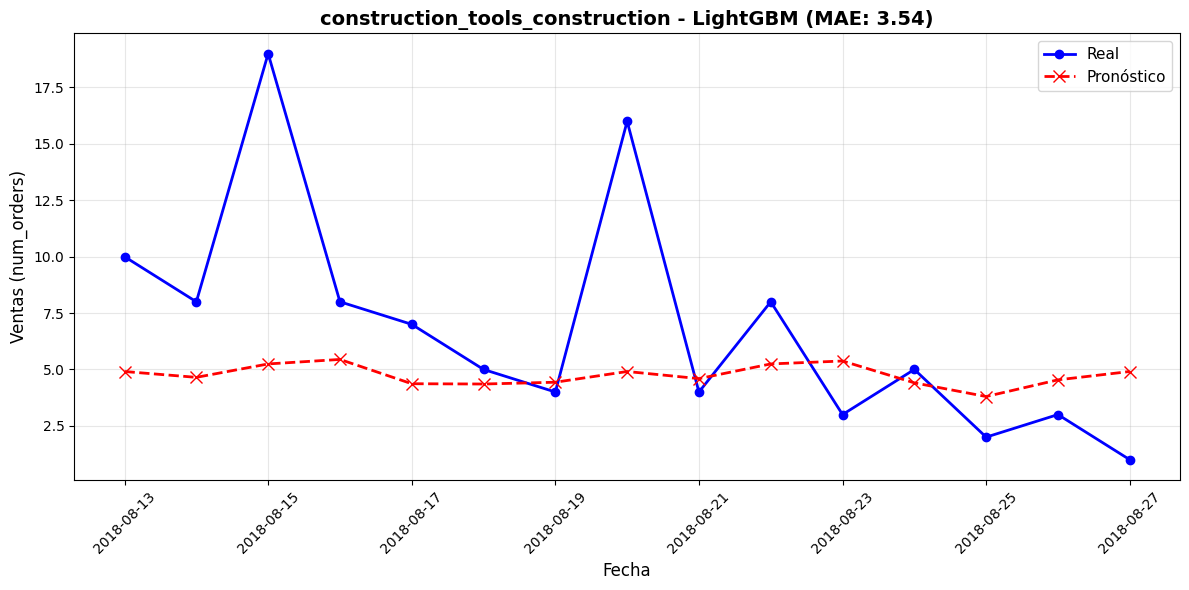

[46/58] Gráfico: housewares - RandomForest


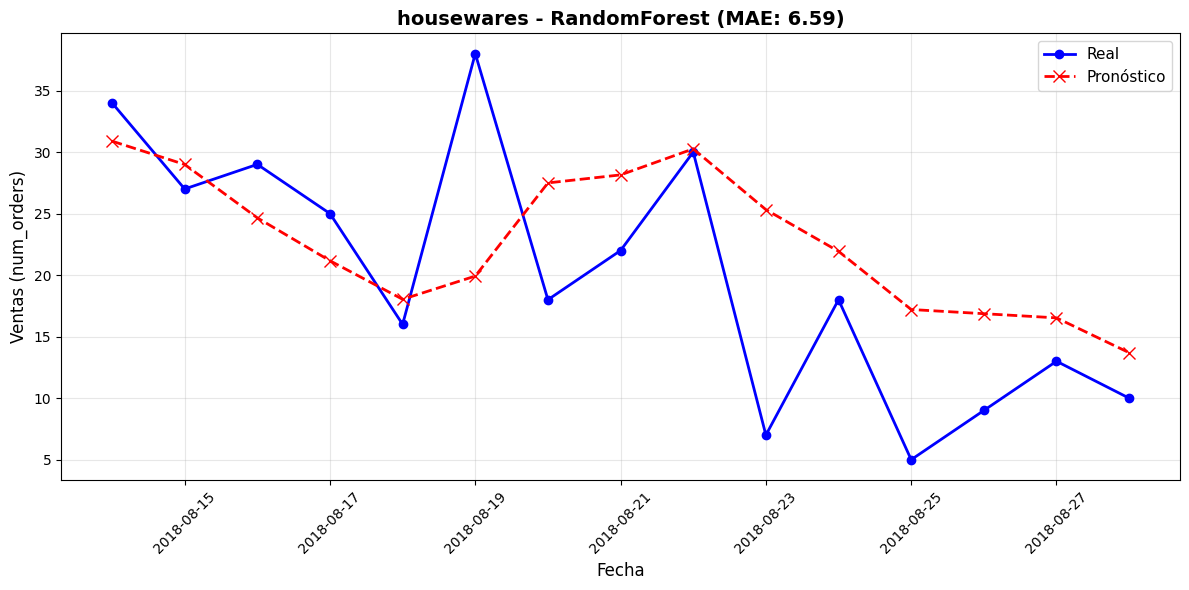

[47/58] Gráfico: food - XGBoost


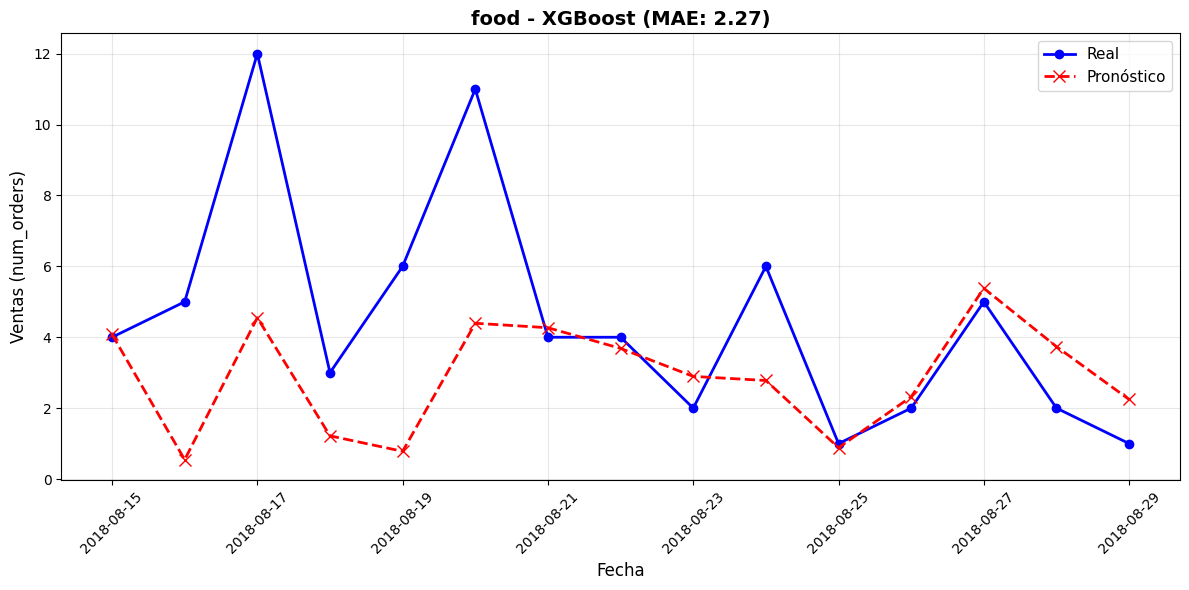

[48/58] Gráfico: furniture_bedroom - XGBoost


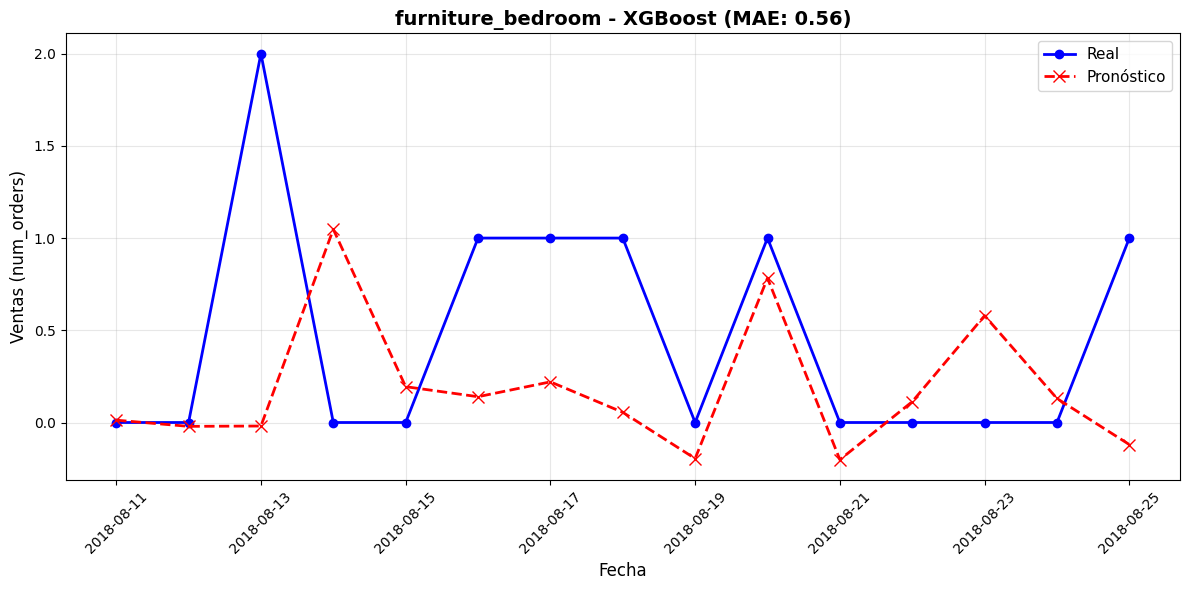

[49/58] Gráfico: home_confort - XGBoost


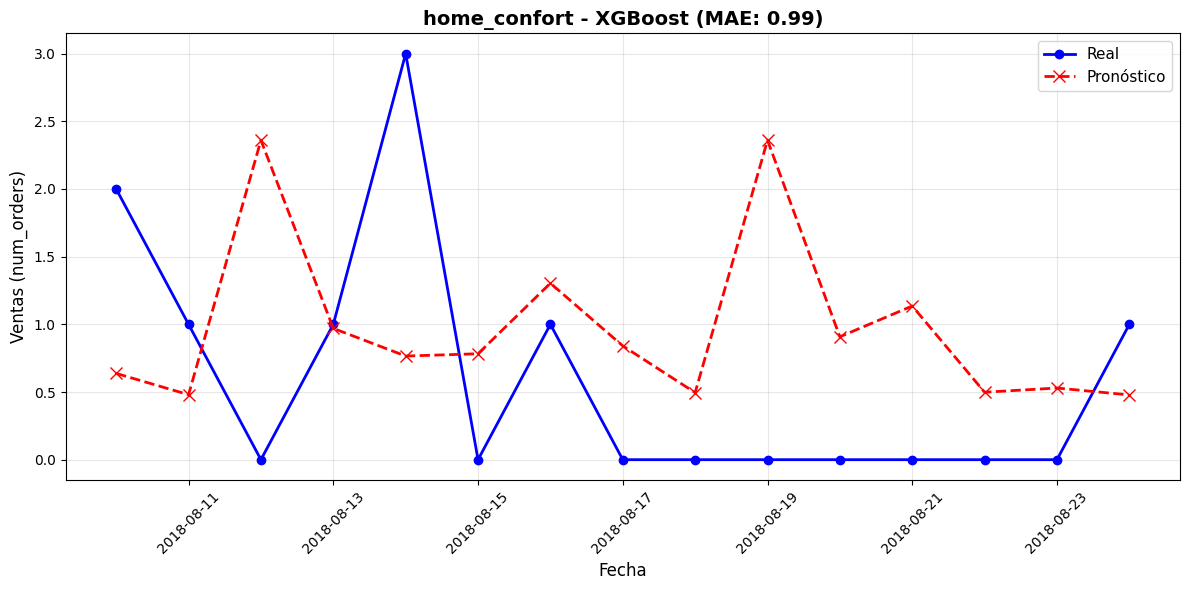

[50/58] Gráfico: electronics - RandomForest


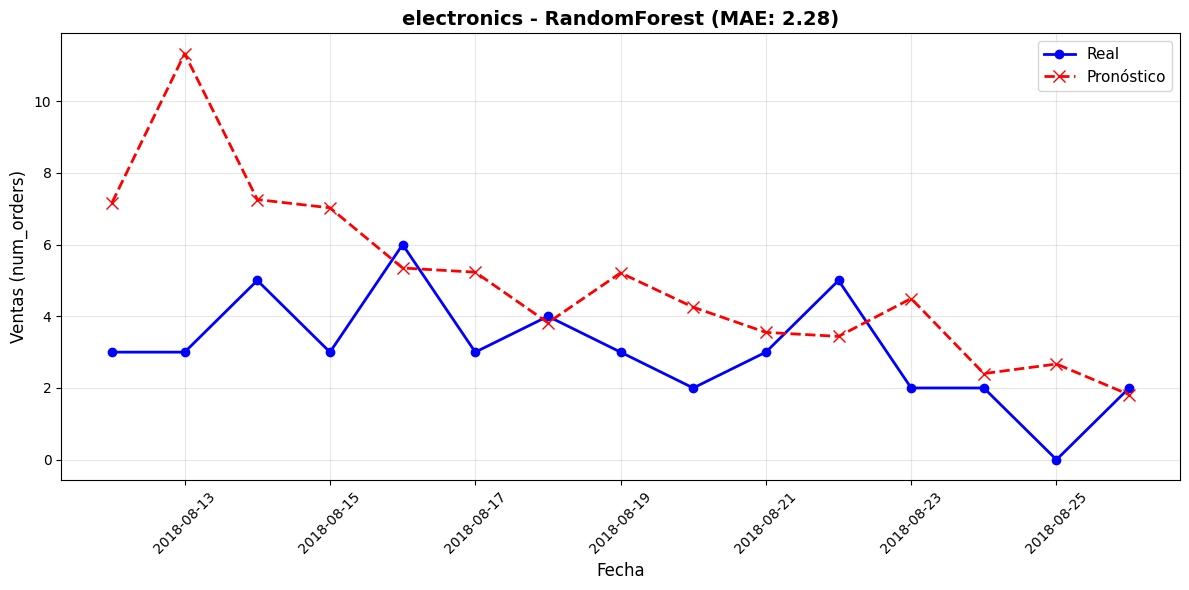

[51/58] Gráfico: toys - XGBoost


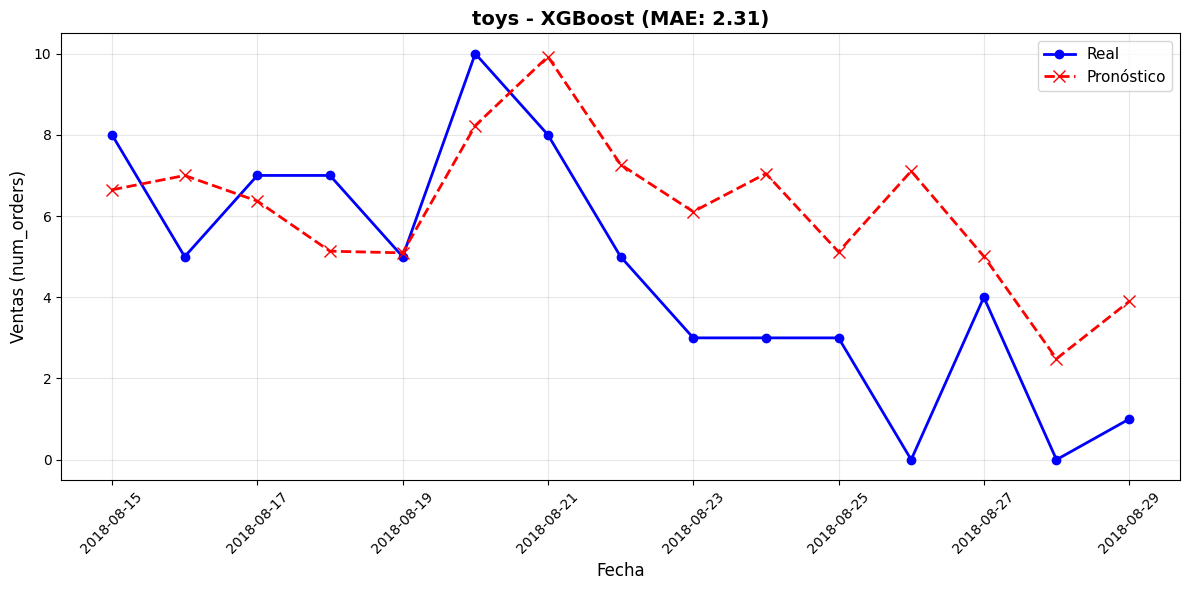

[52/58] Gráfico: watches_gifts - GradientBoosting


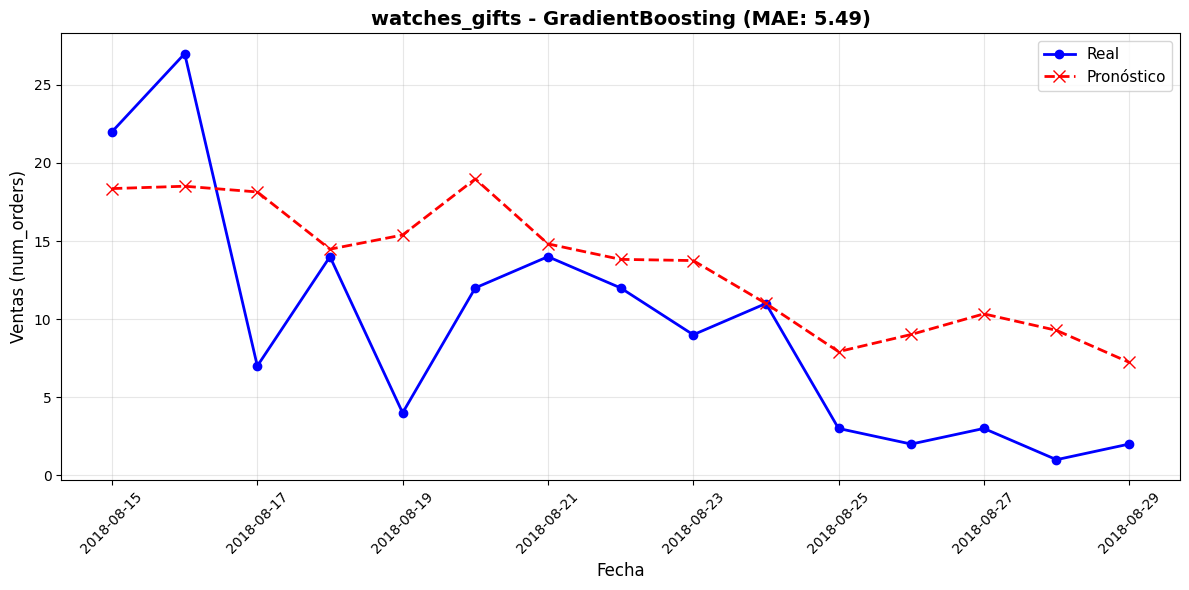

[53/58] Gráfico: sports_leisure - XGBoost


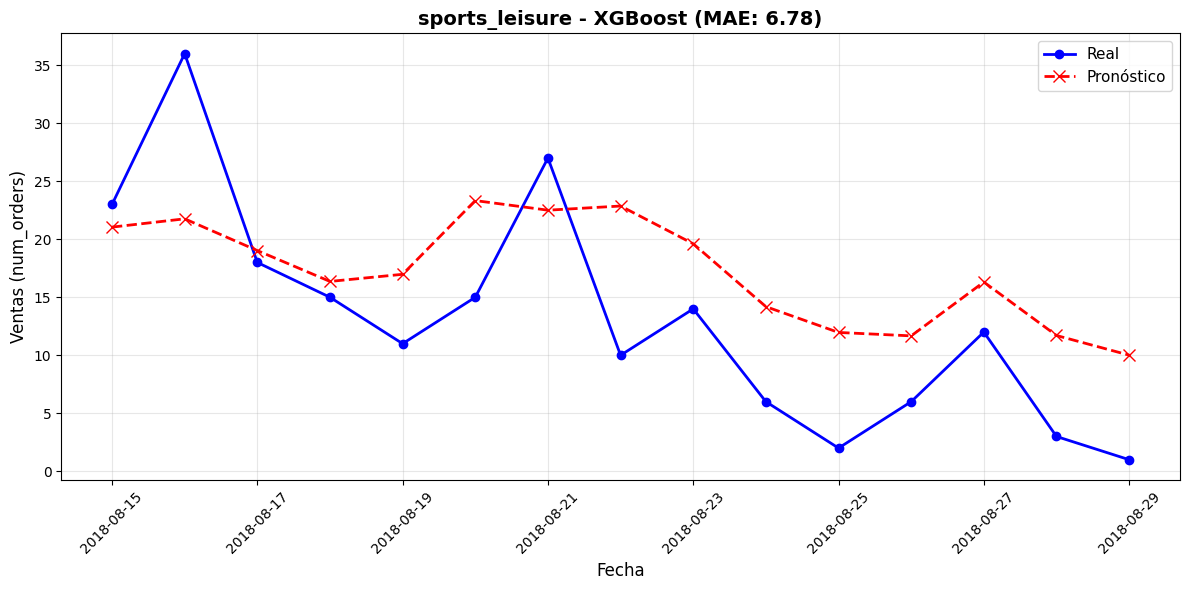

[54/58] Gráfico: cool_stuff - RandomForest


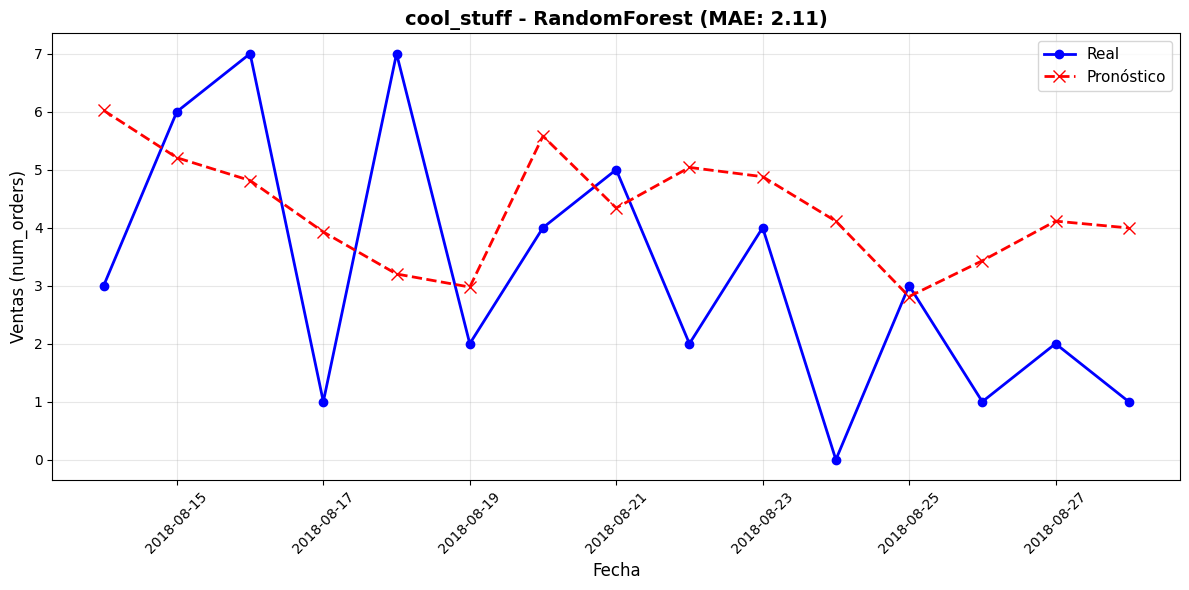

[55/58] Gráfico: baby - GradientBoosting


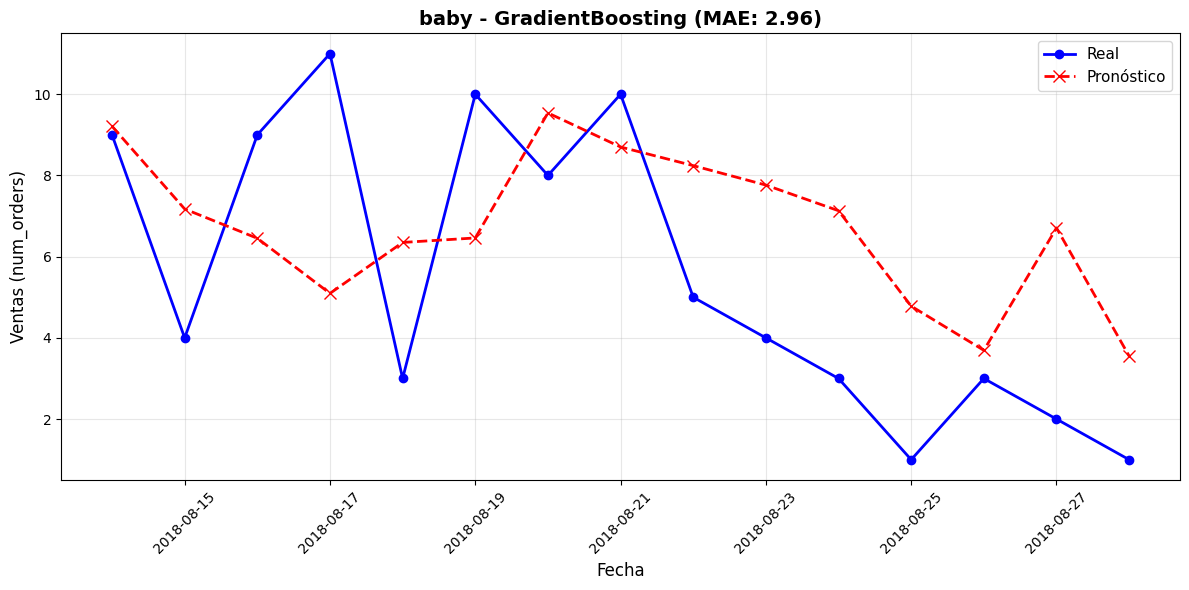

[56/58] Gráfico: telephony - RandomForest


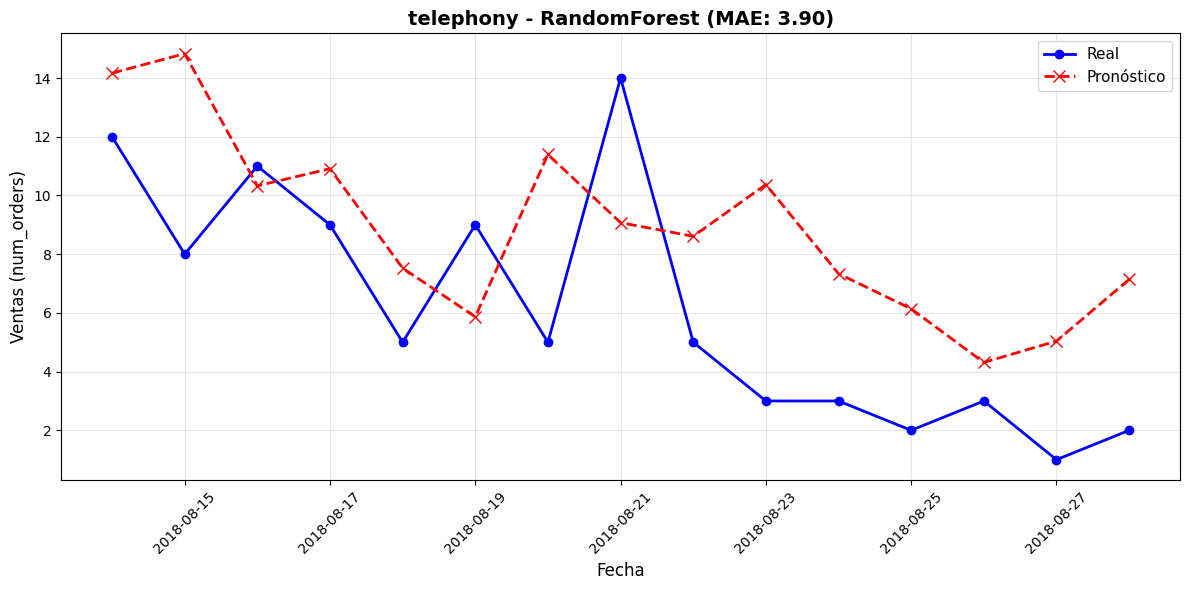

[57/58] Gráfico: health_beauty - LightGBM


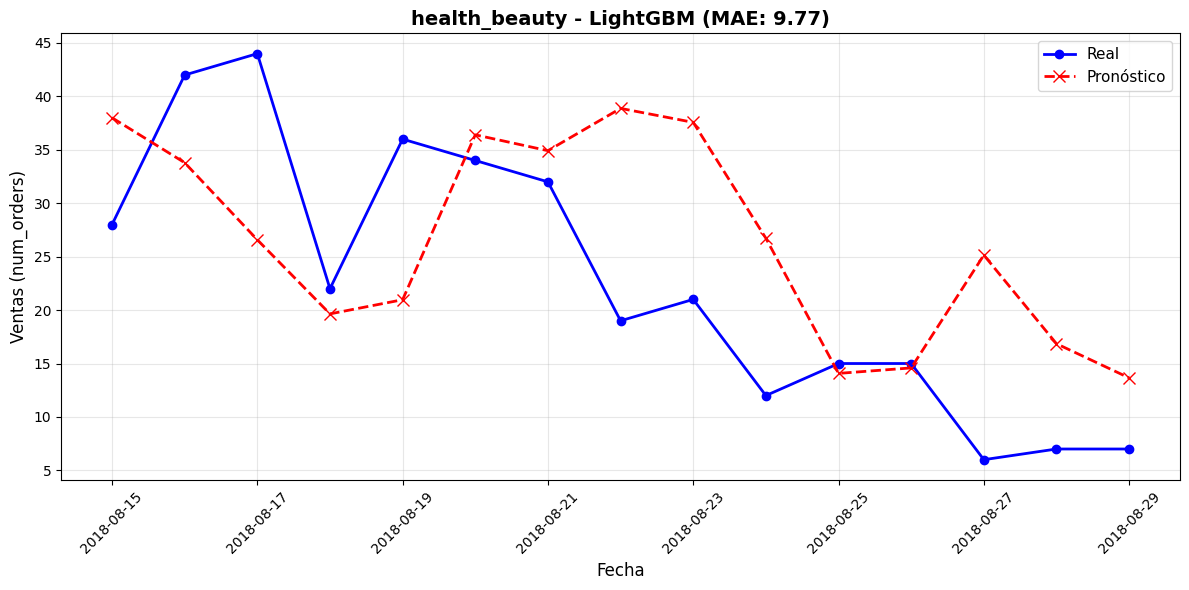

[58/58] Gráfico: garden_tools - RandomForest


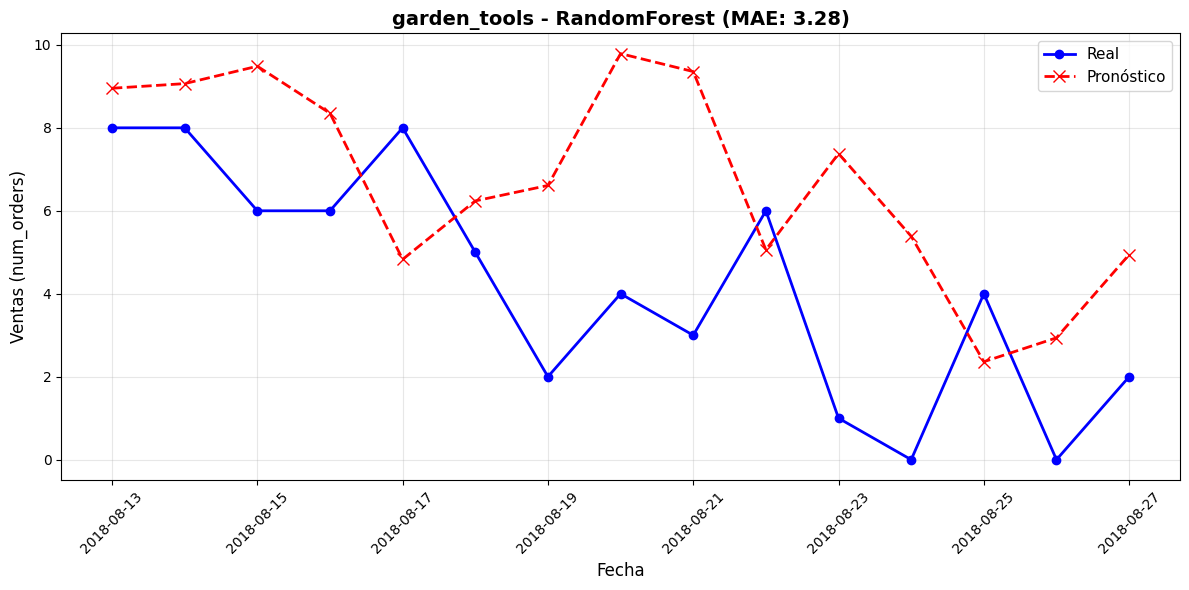


✅ Todos los gráficos generados correctamente.


In [39]:

def plot_forecast(y_test, y_pred, dates, category, model_name, mae):
    """Grafica pronóstico vs real para una categoría"""
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test.values, marker='o', label='Real', color='blue', linewidth=2, markersize=6)
    plt.plot(dates, y_pred, marker='x', label='Pronóstico', color='red', linewidth=2, linestyle='--', markersize=8)
    plt.title(f'{category} - {model_name} (MAE: {mae:.2f})', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Ventas (num_orders)', fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generar gráficos para todas las categorías
print("📈 Generando gráficos de pronóstico vs real para cada categoría...\n")

for idx, row in tuned_results_df.iterrows():
    category = row['category']
    
    if category in tuned_models_data:
        data = tuned_models_data[category]
        print(f"[{idx+1}/{len(tuned_results_df)}] Gráfico: {category} - {data['model_name']}")
        
        plot_forecast(
            data['y_test'], 
            data['predictions'], 
            data['test_dates'], 
            category, 
            data['model_name'],
            row['MAE_tuned']
        )

print("\n✅ Todos los gráficos generados correctamente.")
